# Project- Time Series

Basic Modules

In [8]:
# Import basic modules
import sklearn
import datetime
import warnings
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.stats as ss
import seaborn as sns
import xgboost as xgb

from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from pandas.api.types import CategoricalDtype
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error,mean_absolute_percentage_error

from xgboost import plot_importance, plot_tree

sns.set()
warnings.filterwarnings("ignore")
path= '../datasets'

In [2]:
#!pip install --upgrade statsmodels
#!pip install --upgrade scikit-learn
#!pip install --upgrade xgboost

### Exploración de datos

Los datos fueron obtenidos de la pagina de flujo vehicular de la  Ciudad de Buenos Aires, los datasets se presentan en formato anual en este proyecto se considerara la informacion de los años 2017, 2018 y 2019 para predecir el flujo vehicular en una autopista de la Ciudad de Buenos Aires, Argentina.

**Preparación del Dataset**

In [203]:
data_2017 = pd.read_csv(path+'/flujo-vehicular-2017.csv', sep =',')
data_2018 = pd.read_csv(path+'/flujo-vehicular-2018.csv', sep =',')
data_2019 = pd.read_csv(path+'/flujo-vehicular-2019.csv', sep =',')

In [204]:
#columns
data_2017.info()
data_2018.info()
data_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372645 entries, 0 to 1372644
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1372645 non-null  int64 
 1   fecha           1372645 non-null  object
 2   hora_inicio     1372645 non-null  int64 
 3   hora_fin        1372645 non-null  int64 
 4   dia             1372645 non-null  object
 5   estacion        1372645 non-null  object
 6   sentido         1372645 non-null  object
 7   tipo_vehiculo   1372645 non-null  object
 8   forma_pago      1372645 non-null  object
 9   cantidad_pasos  1372645 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 104.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375908 entries, 0 to 1375907
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1375908 non-null  int64 
 1   fecha           1375908 non

In [205]:
dataframes=[data_2017,data_2018,data_2019]
temp=all([len(dataframes[0].columns.intersection(df.columns)) 
      == dataframes[0].shape[1] for df in dataframes])
print('dataframes tienen las mismas columnas?\n',temp)

dataframes tienen las mismas columnas?
 True


In [206]:
data_2019.head(2)

periodo       fecha  hora_inicio  hora_fin     dia estacion sentido  \
0     2019  2019-01-01            0         1  Martes  Alberti  Centro   
1     2019  2019-01-01            0         1  Martes  Alberti  Centro   

  tipo_vehiculo  forma_pago  cantidad_pasos  
0       Liviano  NO COBRADO              22  
1       Liviano    TELEPASE               6

Información por columna:

- **periodo**: año del dataset
- **fecha**: año dia mes de la observacion
- **hora_inicio** hora de inicio de la cuenta de vehiculos 
- **hora_fin** hora de fin de la cuenta de vehiculos 
- **dia**: dia de la semana 
- **estacion**: estaciones de peaje, difieren levemente entre los años
- **sentido**: Centro o Provincia
- **tipo_vehiculo**: Liviano o Pesado
- **forma_pago**: Hay varias y varian entre los años.
- **cantidad_pasos**: Cantidad de vehiculos en el intervalo de `hora_inicio` y `hora_fin`

Entonces los 3 datasets cuentan con la misma estructura: columnas con igual nomenclatura y tipo de variable, por ende son concatenables.

In [207]:
df = pd.concat([data_2019, data_2018, data_2017])
print('Number of rows:',df.shape[0])
print('Number of columns:',df.shape[1])
print('First five rows:')
df.head()

Number of rows: 3560706
Number of columns: 10
First five rows:


periodo       fecha  hora_inicio  hora_fin     dia    estacion    sentido  \
0     2019  2019-01-01            0         1  Martes     Alberti     Centro   
1     2019  2019-01-01            0         1  Martes     Alberti     Centro   
2     2019  2019-01-01            0         1  Martes     Alberti  Provincia   
3     2019  2019-01-01            0         1  Martes     Alberti  Provincia   
4     2019  2019-01-01            0         1  Martes  Avellaneda     Centro   

  tipo_vehiculo  forma_pago  cantidad_pasos  
0       Liviano  NO COBRADO              22  
1       Liviano    TELEPASE               6  
2       Liviano  NO COBRADO              53  
3       Liviano    TELEPASE              18  
4       Liviano    EFECTIVO              16

In [208]:
tiposdf = df.dtypes
print('Data type of each column:')
print(tiposdf)

Data type of each column:
periodo            int64
fecha             object
hora_inicio        int64
hora_fin           int64
dia               object
estacion          object
sentido           object
tipo_vehiculo     object
forma_pago        object
cantidad_pasos     int64
dtype: object


Informacion por tipo de variable:
- Numericas: `periodo`, `hora_inicio`, `hora_fin` y `cantidad_pasos`
- Categoricas:`estacion`, `sentido`, `tipo_vehiculo` y `forma_pago`
- Fecha: `fecha` con pendiente transformacion a datetime

In [209]:
#hora inicio y hora fin van de 0 a 23 hrs
df.describe()

periodo   hora_inicio      hora_fin  cantidad_pasos
count  3.560706e+06  3.560706e+06  3.560706e+06    3.560706e+06
mean   2.017843e+03  1.195313e+01  1.207470e+01    1.052144e+02
std    7.673381e-01  6.583099e+00  6.651320e+00    3.206278e+02
min    2.017000e+03  0.000000e+00  0.000000e+00    1.000000e+00
25%    2.017000e+03  7.000000e+00  7.000000e+00    2.000000e+00
50%    2.018000e+03  1.200000e+01  1.200000e+01    8.000000e+00
75%    2.018000e+03  1.700000e+01  1.800000e+01    3.400000e+01
max    2.019000e+03  2.300000e+01  2.300000e+01    6.677000e+03

In [210]:
#se formatea fecha como datetime
df.rename(columns={'fecha': 'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df['year'] = df.Date.dt.year
df['month'] = df.Date.dt.month
df['day'] = df.Date.dt.day
df['DateTime'] = pd.to_datetime({'year':df.year, 'month': df.month, 'day': df.day,'hour':df.hora_inicio})
df.head()

periodo       Date  hora_inicio  hora_fin     dia    estacion    sentido  \
0     2019 2019-01-01            0         1  Martes     Alberti     Centro   
1     2019 2019-01-01            0         1  Martes     Alberti     Centro   
2     2019 2019-01-01            0         1  Martes     Alberti  Provincia   
3     2019 2019-01-01            0         1  Martes     Alberti  Provincia   
4     2019 2019-01-01            0         1  Martes  Avellaneda     Centro   

  tipo_vehiculo  forma_pago  cantidad_pasos  year  month  day   DateTime  
0       Liviano  NO COBRADO              22  2019      1    1 2019-01-01  
1       Liviano    TELEPASE               6  2019      1    1 2019-01-01  
2       Liviano  NO COBRADO              53  2019      1    1 2019-01-01  
3       Liviano    TELEPASE              18  2019      1    1 2019-01-01  
4       Liviano    EFECTIVO              16  2019      1    1 2019-01-01

In [211]:
#head y tail del dataset Inicial el 01 de enero del 2017, termina el 31 de diciembre del 2019
print(df['DateTime'].min())
print(df['DateTime'].max())

2017-01-01 00:00:00
2019-12-31 23:00:00


In [212]:
def missing(dfx1):
    print('--Columnas con valores faltantes--')
    dfv=pd.DataFrame(dfx1.isna().sum()[dfx1.isna().sum()>0])
    dfv.columns=['cant']
    dfv['%']=round((dfv.cant*100)/dfx1.shape[0],2)
    print(dfv)
missing(df)

--Columnas con valores faltantes--
Empty DataFrame
Columns: [cant, %]
Index: []


#### Univariate Analysis: **`estacion`**

In [213]:
print(df['estacion'].unique())

['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB' 'Alberdi' 'Dellepiane Centro' 'Dellepiane Liniers']


In [214]:
d=df.groupby(['estacion','periodo'])['Date'].count().astype(int).reset_index()
d.sort_values(["periodo",'estacion'], axis = 0, ascending = True)

estacion  periodo    Date
0              Alberdi     2017  150583
3           Avellaneda     2017  391842
7    Dellepiane Centro     2017  180140
9   Dellepiane Liniers     2017  176984
11               Illia     2017  291900
15              Retiro     2017  133584
18            Salguero     2017   23381
21           Sarmiento     2017   24231
1              Alberdi     2018  153037
4           Avellaneda     2018  394371
8    Dellepiane Centro     2018  176745
10  Dellepiane Liniers     2018  176696
12               Illia     2018  299519
16              Retiro     2018  119969
19            Salguero     2018   28058
22           Sarmiento     2018   27513
2              Alberti     2019  132279
5           Avellaneda     2019  186443
6           Dellepiane     2019  187600
13               Illia     2019  161133
14                 PDB     2019   40964
17              Retiro     2019   53975
20            Salguero     2019   24869
23           Sarmiento     2019   24890

Observaciones:
En el 2017 y 2018 tiene una estructura similar, sin embargo ocurren cambios en el  2019 
- "Alberdi" cambia a "Alberti" 
- Tambien 'Dellepiane Centro' 'Dellepiane Liniers' se unifican en  'Dellepiane' 
- Aparece una estacion denominada "PDB"

In [215]:
df.estacion.replace({'Dellepiane Centro': 'Dellepiane', 'Dellepiane Liniers': 'Dellepiane',
                 'Alberdi': 'Alberti'}, inplace=True)

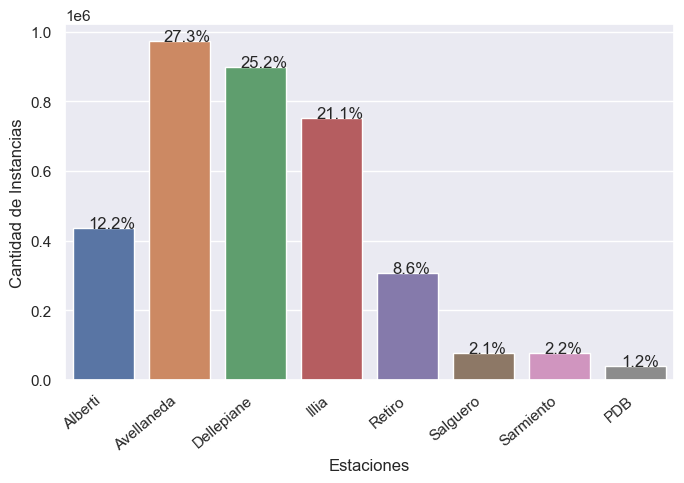

In [216]:
def without_hue(plot, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.20
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(7,5))
ax=sns.countplot(x='estacion',data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha='right')
ax.set(ylabel = "Cantidad de Instancias")
ax.set(xlabel = "Estaciones")
without_hue(ax,df.estacion)

PDB ingreso como una nueva estacion en el 2019 sin embargo no registro muchos vehiculos, las estaciones con mayor presencia de vehiculos fueron Avellaneda, Dellepiane e Illia

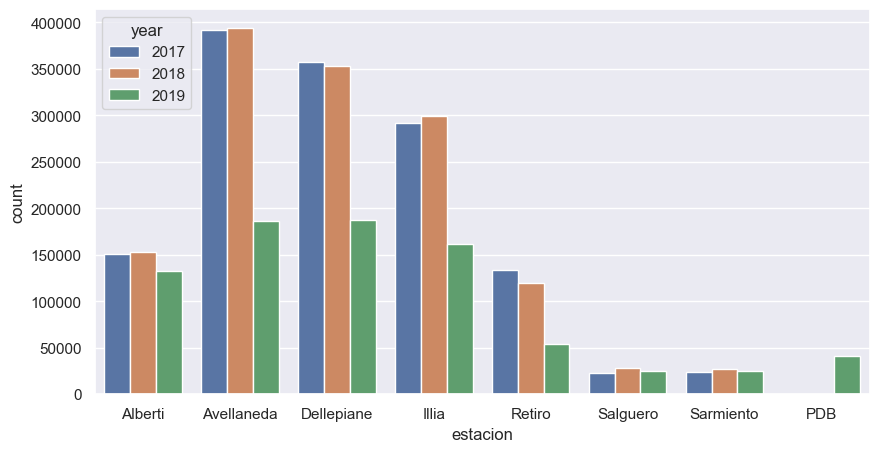

In [218]:
dimension=(10,5)
fig,(ax)=plt.subplots(1,1,figsize=dimension)
ax=sns.countplot(x = 'estacion', hue = 'year', data = df)
# Show the plot
plt.show()

Dado que el objetivo sera predecir el trafico el tráfico en la autopista Illia para el último trimestre del 2019, analizare las variables: **`forma_pago`, `sentido`,`tipo_vehiculo`**.

#### Bivariate Analysis 

Analisis de cada variable categoria sola y vs el trafico

`sentido`

<AxesSubplot:xlabel='sentido', ylabel='cantidad_pasos'>

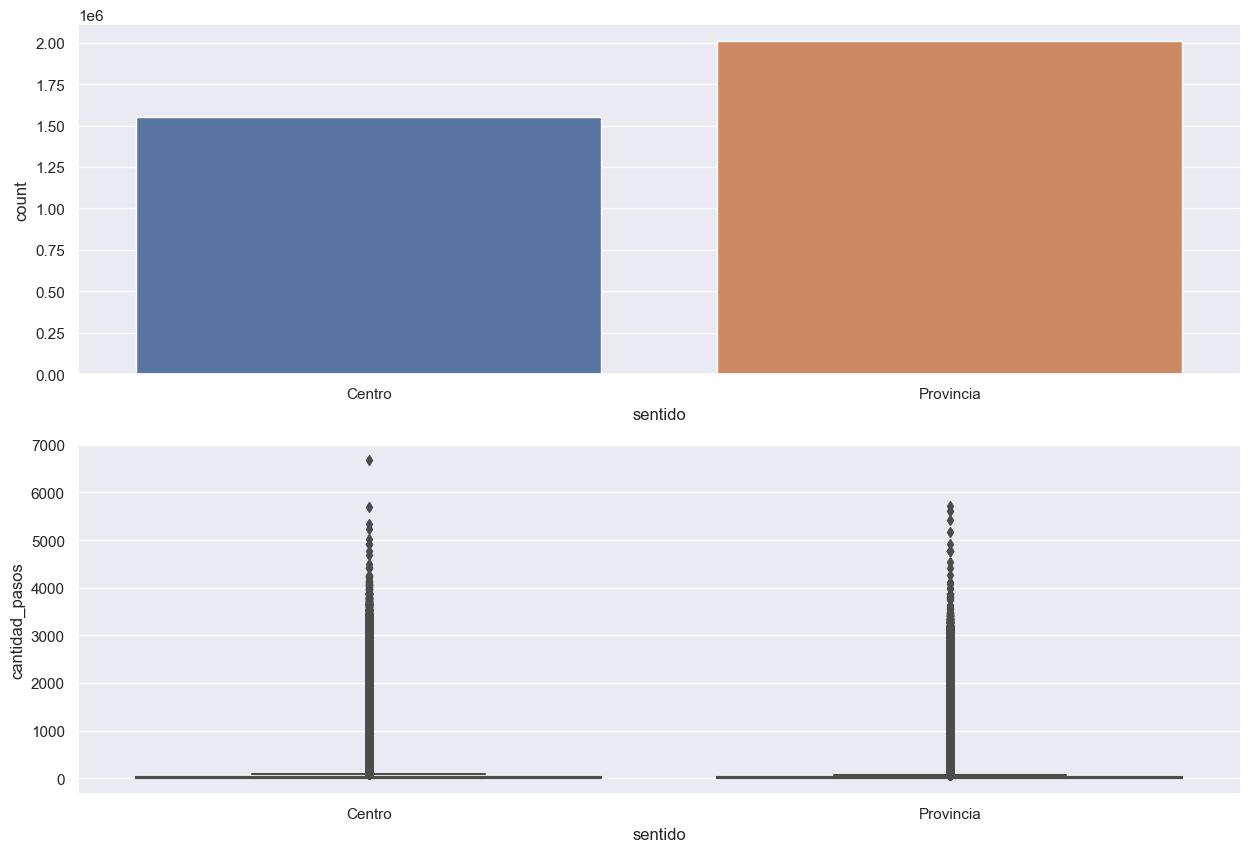

In [219]:
fig = plt.figure()

ax1 = fig.add_subplot(2,1,1) 
sns.countplot(data = df, x = 'sentido', ax = ax1)

ax2 = fig.add_subplot(2,1,2) 
sns.boxplot(data = df, x='sentido', y='cantidad_pasos' , ax = ax2)

In [220]:
df[df["sentido"]=="Provincia"].shape[0]

2010855

Los sentidos son: centro y provincia, provincia esta relacionada con mas de la mitad del dataset por ende podria ser un indicador importante.

`tipo_vehiculo`

<AxesSubplot:xlabel='tipo_vehiculo', ylabel='cantidad_pasos'>

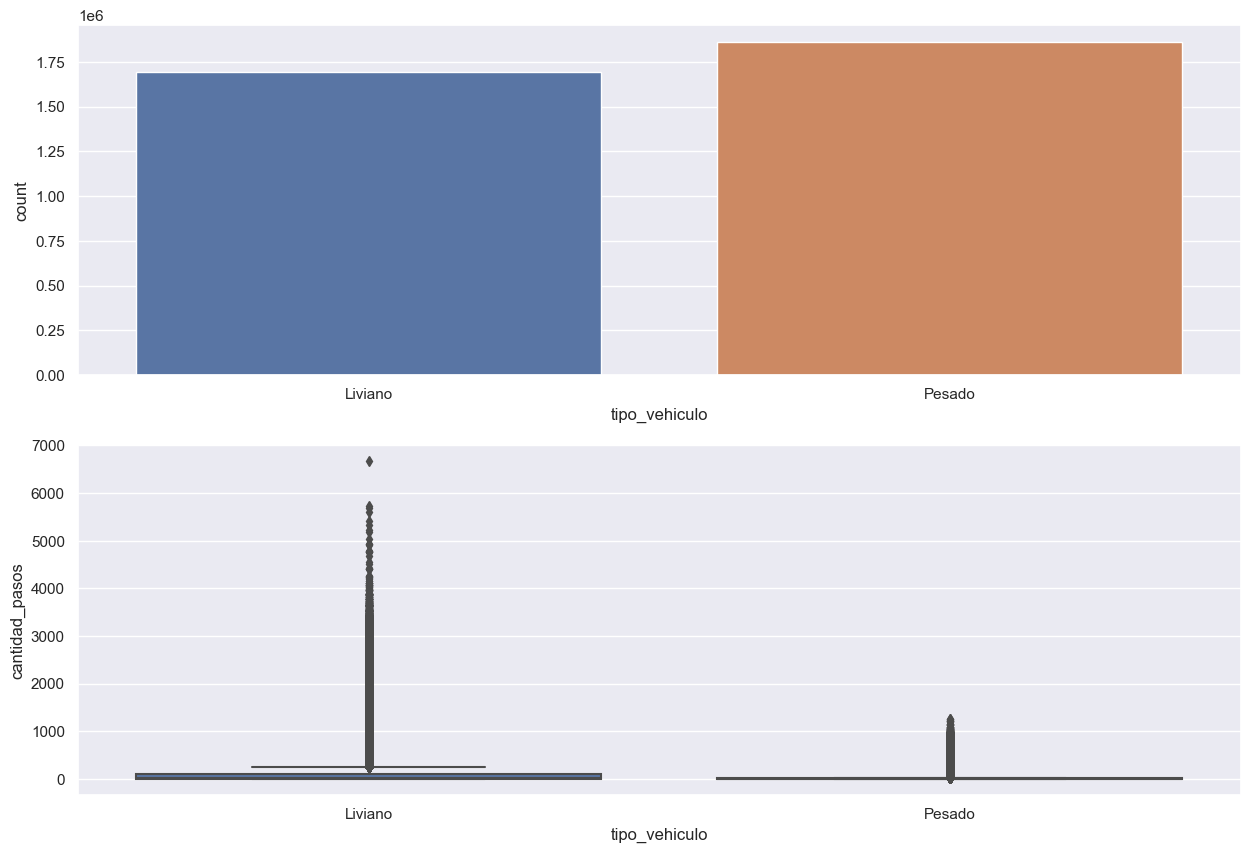

In [221]:
fig = plt.figure()

ax1 = fig.add_subplot(2,1,1) 
sns.countplot(data = df, x = 'tipo_vehiculo', ax = ax1)

ax2 = fig.add_subplot(2,1,2) 
sns.boxplot(data = df, x='tipo_vehiculo', y='cantidad_pasos' , ax = ax2)

Los tipos de vehiculos son: liviano y pesado, liviano esta relacionada con una menor cantidad de observaciones, pero podria influir en el forecasting de un alto trafico

`forma_pago`

In [222]:
df.forma_pago.unique()

array(['NO COBRADO', 'TELEPASE', 'EFECTIVO', 'EXENTO', 'INFRACCION',
       'T. DISCAPACIDAD', 'TARJETA DISCAPACIDAD', 'MONEDERO', 'Otros'],
      dtype=object)

In [223]:
df.forma_pago.replace({'TARJETA DISCAPACIDAD': 'T. DISCAPACIDAD'}, inplace=True)

[Text(0.5, 0, 'forma_pago')]

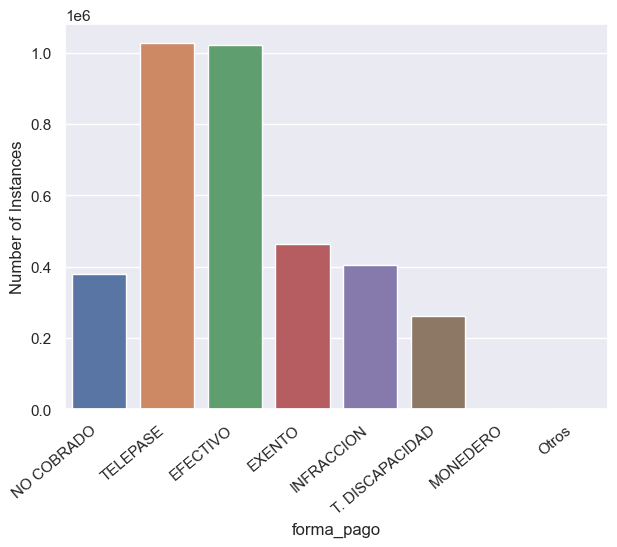

In [224]:
plt.figure(figsize=(7,5))
ax=sns.countplot(x='forma_pago',data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha='right')
ax.set(ylabel = "Number of Instances")
ax.set(xlabel = "forma_pago")

[Text(0.5, 0, 'forma_pago')]

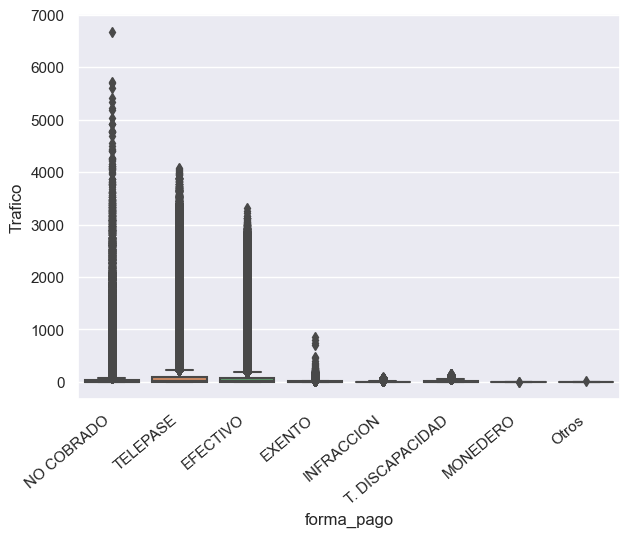

In [225]:
plt.figure(figsize=(7,5))
ax=sns.boxplot(data = df, x='forma_pago', y='cantidad_pasos')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha='right')
ax.set(ylabel = "Trafico")
ax.set(xlabel = "forma_pago")

In [226]:
df.forma_pago.value_counts()

TELEPASE           1027861
EFECTIVO           1020176
EXENTO              464708
INFRACCION          405034
NO COBRADO          380450
T. DISCAPACIDAD     262455
MONEDERO                14
Otros                    8
Name: forma_pago, dtype: int64

De todas las formas de pago: aquellas con menor presencia son `MONEDERO` Y `Otros`, dada la poca explicacion de alto trafico y que afectan 22 filas las considerare como outliers, limitare el dataset a los otros tipos de pago.

In [227]:
indx_drop=df[(df.forma_pago=='MONEDERO') | (df.forma_pago=='Otros')].index
df.drop(indx_drop, inplace=True)

#### Encoding & Nuevas vars predictoras

Dado que la idea es agrupar por fecha, estacion y hora para hallar el trafico, usare sentido, tipo de vehiculo y forma de pago como indicadores en este caso:

In [228]:
dfEncodedv1= pd.get_dummies(data = df.copy(),
                          columns = ['sentido','tipo_vehiculo','forma_pago'],
                          prefix = ['sentido','tipo_vehiculo','forma_pago'],
                          prefix_sep = '_')

df2=df[(df.forma_pago=="EFECTIVO")&(df.estacion=="Illia")]
dfEncodedv2= pd.get_dummies(data = df2.copy(),
                          columns = ['sentido','tipo_vehiculo'],
                          prefix = ['sentido','tipo_vehiculo'],
                          prefix_sep = '_')

In [229]:
#df general
df1=dfEncodedv1.groupby(by=['estacion','year','month','day','Date','DateTime','hora_inicio'], as_index=False)['cantidad_pasos','sentido_Centro','sentido_Provincia','tipo_vehiculo_Liviano', 'tipo_vehiculo_Pesado',
       'forma_pago_EFECTIVO', 'forma_pago_EXENTO', 'forma_pago_INFRACCION',
       'forma_pago_NO COBRADO', 'forma_pago_T. DISCAPACIDAD',
       'forma_pago_TELEPASE'].sum()

#df orientado a Illia y pago efectivo
df2=dfEncodedv2.groupby(by=['estacion','year','month','day','Date','DateTime','hora_inicio'], as_index=False)['cantidad_pasos','sentido_Centro','sentido_Provincia','tipo_vehiculo_Liviano', 'tipo_vehiculo_Pesado'].sum()

In [230]:
#los indicadores refleja la relacion de la categoria(s) que mas refleja el trafico respecto al total de categorias encontradas para esa observacion
df1["otras_forma_pago"]=(df1["forma_pago_NO COBRADO"]+df1.forma_pago_TELEPASE)/(df1.forma_pago_EFECTIVO+df1.forma_pago_EXENTO+df1.forma_pago_INFRACCION+df1["forma_pago_NO COBRADO"]+df1["forma_pago_T. DISCAPACIDAD"]+df1.forma_pago_TELEPASE)
cols=['sentido_Centro','sentido_Provincia','tipo_vehiculo_Liviano', 'tipo_vehiculo_Pesado', 'forma_pago_EXENTO', 'forma_pago_INFRACCION','forma_pago_NO COBRADO', 'forma_pago_T. DISCAPACIDAD',
       'forma_pago_TELEPASE']
df1.drop(cols, inplace=True, axis=1)
df1.head()

estacion  year  month  day       Date            DateTime  hora_inicio  \
0  Alberti  2017      1    1 2017-01-01 2017-01-01 00:00:00            0   
1  Alberti  2017      1    1 2017-01-01 2017-01-01 01:00:00            1   
2  Alberti  2017      1    1 2017-01-01 2017-01-01 02:00:00            2   
3  Alberti  2017      1    1 2017-01-01 2017-01-01 03:00:00            3   
4  Alberti  2017      1    1 2017-01-01 2017-01-01 04:00:00            4   

   cantidad_pasos  forma_pago_EFECTIVO  otras_forma_pago  
0             104                    0          1.000000  
1             613                    5          0.357143  
2             640                    6          0.285714  
3             380                    4          0.333333  
4             168                    4          0.300000

In [231]:
df2["sentido_prov"]=df2.sentido_Provincia/(df2.sentido_Centro+df2.sentido_Provincia)
df2["vehiculo_liv"]=df2.tipo_vehiculo_Liviano/(df2.tipo_vehiculo_Liviano+df2.tipo_vehiculo_Pesado)
cols=['sentido_Centro','sentido_Provincia','tipo_vehiculo_Liviano', 'tipo_vehiculo_Pesado','estacion']
df2.drop(cols, inplace=True, axis=1)
df2.head()

year  month  day       Date            DateTime  hora_inicio  \
0  2017      1    1 2017-01-01 2017-01-01 00:00:00            0   
1  2017      1    1 2017-01-01 2017-01-01 01:00:00            1   
2  2017      1    1 2017-01-01 2017-01-01 02:00:00            2   
3  2017      1    1 2017-01-01 2017-01-01 03:00:00            3   
4  2017      1    1 2017-01-01 2017-01-01 04:00:00            4   

   cantidad_pasos  sentido_prov  vehiculo_liv  
0               1      0.000000      1.000000  
1            1374      0.500000      0.666667  
2            1734      0.500000      0.666667  
3            1247      0.428571      0.571429  
4             579      0.400000      0.800000

#### Valores Faltantes

In [232]:
#Checking the tail of the data for each year
for i in df1.estacion.unique():
    temp2=df1[(df1.estacion==i)]
    for temp in temp2.year.unique():
        temp1=temp2[['DateTime']][(temp2.year==temp)]
        temp1 = temp1.sort_values(by='DateTime')
        print(f"Para {i} en el {temp} la fecha minima es: {temp1['DateTime'].min()}")
        print(f"Para {i} en el {temp} la fecha maxima es: {temp1['DateTime'].max()}")

Para Alberti en el 2017 la fecha minima es: 2017-01-01 00:00:00
Para Alberti en el 2017 la fecha maxima es: 2017-12-31 23:00:00
Para Alberti en el 2018 la fecha minima es: 2018-01-01 00:00:00
Para Alberti en el 2018 la fecha maxima es: 2018-12-31 23:00:00
Para Alberti en el 2019 la fecha minima es: 2019-01-01 00:00:00
Para Alberti en el 2019 la fecha maxima es: 2019-12-31 23:00:00
Para Avellaneda en el 2017 la fecha minima es: 2017-01-01 00:00:00
Para Avellaneda en el 2017 la fecha maxima es: 2017-12-31 23:00:00
Para Avellaneda en el 2018 la fecha minima es: 2018-01-01 00:00:00
Para Avellaneda en el 2018 la fecha maxima es: 2018-12-31 23:00:00
Para Avellaneda en el 2019 la fecha minima es: 2019-01-01 00:00:00
Para Avellaneda en el 2019 la fecha maxima es: 2019-12-31 23:00:00
Para Dellepiane en el 2017 la fecha minima es: 2017-01-01 00:00:00
Para Dellepiane en el 2017 la fecha maxima es: 2017-12-31 23:00:00
Para Dellepiane en el 2018 la fecha minima es: 2018-01-01 00:00:00
Para Dellepia

Estacion PDB empezo a recolectar data el 6 de enero del 2019

In [233]:
#Checking the tail of the data for each year
for temp in df2.year.unique():
    temp1=df2[['DateTime']][(df2.year==temp)]
    temp1 = temp1.sort_values(by='DateTime')
    print(f"Para Illia en el {temp} la fecha minima es: {temp1['DateTime'].min()}")
    print(f"Para Illia en el {temp} la fecha maxima es: {temp1['DateTime'].max()}")

Para Illia en el 2017 la fecha minima es: 2017-01-01 00:00:00
Para Illia en el 2017 la fecha maxima es: 2017-12-31 23:00:00
Para Illia en el 2018 la fecha minima es: 2018-01-01 00:00:00
Para Illia en el 2018 la fecha maxima es: 2018-12-31 23:00:00
Para Illia en el 2019 la fecha minima es: 2019-01-01 01:00:00
Para Illia en el 2019 la fecha maxima es: 2019-12-31 23:00:00


In [234]:
#checking missing days
missing_days={}
for i in df1.estacion.unique():
    temp2=df1[(df1.estacion==i)]
    missing_day=pd.date_range(start=temp2.Date.min(), end=temp2.Date.max()).difference(temp2.Date)
    missing_days[i]=missing_day
    
#checking missing days Illia
missing_days2=pd.date_range(start=df2.Date.min(), end=df2.Date.max()).difference(df2.Date)

In [235]:
missing_days

{'Alberti': DatetimeIndex([], dtype='datetime64[ns]', freq=None),
 'Avellaneda': DatetimeIndex([], dtype='datetime64[ns]', freq=None),
 'Dellepiane': DatetimeIndex([], dtype='datetime64[ns]', freq=None),
 'Illia': DatetimeIndex([], dtype='datetime64[ns]', freq=None),
 'PDB': DatetimeIndex(['2019-01-13', '2019-01-14', '2019-01-15', '2019-01-16',
                '2019-01-17', '2019-01-18', '2019-01-19', '2019-01-20',
                '2019-01-21', '2019-01-22',
                ...
                '2019-11-01', '2019-11-02', '2019-11-03', '2019-11-04',
                '2019-11-05', '2019-12-01', '2019-12-02', '2019-12-03',
                '2019-12-04', '2019-12-05'],
               dtype='datetime64[ns]', length=144, freq=None),
 'Retiro': DatetimeIndex(['2018-11-30'], dtype='datetime64[ns]', freq=None),
 'Salguero': DatetimeIndex(['2017-02-09', '2017-02-10', '2017-02-11', '2017-02-12',
                '2017-02-13', '2017-02-14', '2017-03-01', '2017-09-11',
                '2017-09-12', '2

In [236]:
#considerando solo pago efectivo para Illia
missing_days2

DatetimeIndex(['2018-06-25', '2018-09-25', '2018-11-30', '2019-05-29'], dtype='datetime64[ns]', freq=None)

In [237]:
##checking missing hours
missing_dateshours=[]
for w in df1.estacion.unique():
    dftemp0=df1[(df1.estacion==w)]
    for a in dftemp0.year.unique():
        dftemp1=dftemp0[(dftemp0.year==a)]
        for b in dftemp1.month.unique():
            dftemp2=dftemp1[(dftemp1.month==b)]
            for c in dftemp2.day.unique():
                dftemp3=dftemp2[(dftemp2.day==c)]
                for d in range(0,24):  #list of all possible hous
                    if d not in list(dftemp3.hora_inicio):
                        r = datetime.datetime(year=a, month=b, day=c,hour=d)
                        missing_dateshours.append([r,w])

missing_dateshours = pd.DataFrame(missing_dateshours, columns = ['DateTime','estacion'])

In [238]:
missing_dateshours

DateTime   estacion
0   2017-04-14 07:00:00    Alberti
1   2019-02-21 05:00:00    Alberti
2   2019-02-21 06:00:00    Alberti
3   2019-06-03 02:00:00    Alberti
4   2019-06-03 03:00:00    Alberti
..                  ...        ...
741 2019-08-30 03:00:00  Sarmiento
742 2019-08-30 04:00:00  Sarmiento
743 2019-08-30 05:00:00  Sarmiento
744 2019-08-30 06:00:00  Sarmiento
745 2019-08-30 07:00:00  Sarmiento

[746 rows x 2 columns]

In [239]:
##checking missing hours per Illia
missing_dateshours2=[]
for a in df2.year.unique():
    dftemp1=df2[(df2.year==a)]
    for b in dftemp1.month.unique():
        dftemp2=dftemp1[(dftemp1.month==b)]
        for c in dftemp2.day.unique():
            dftemp3=dftemp2[(dftemp2.day==c)]
            for d in range(0,24):  #list of all possible hous
                if d not in list(dftemp3.hora_inicio):
                    r = datetime.datetime(year=a, month=b, day=c,hour=d)
                    missing_dateshours2.append([r])

missing_dateshours2 = pd.DataFrame(missing_dateshours2, columns = ['DateTime'])

In [240]:
list(missing_dateshours2.DateTime.dt.date)

[datetime.date(2017, 4, 6),
 datetime.date(2017, 4, 6),
 datetime.date(2017, 4, 6),
 datetime.date(2017, 4, 6),
 datetime.date(2017, 4, 6),
 datetime.date(2017, 4, 6),
 datetime.date(2017, 4, 6),
 datetime.date(2017, 4, 6),
 datetime.date(2017, 4, 6),
 datetime.date(2017, 4, 6),
 datetime.date(2017, 4, 6),
 datetime.date(2017, 4, 6),
 datetime.date(2017, 4, 6),
 datetime.date(2017, 4, 6),
 datetime.date(2017, 4, 6),
 datetime.date(2017, 4, 6),
 datetime.date(2017, 4, 6),
 datetime.date(2017, 4, 6),
 datetime.date(2017, 4, 6),
 datetime.date(2017, 4, 6),
 datetime.date(2017, 4, 6),
 datetime.date(2017, 4, 6),
 datetime.date(2017, 4, 6),
 datetime.date(2017, 5, 9),
 datetime.date(2017, 5, 9),
 datetime.date(2017, 5, 9),
 datetime.date(2017, 5, 9),
 datetime.date(2017, 5, 9),
 datetime.date(2017, 9, 10),
 datetime.date(2017, 9, 10),
 datetime.date(2017, 9, 10),
 datetime.date(2017, 11, 4),
 datetime.date(2017, 11, 4),
 datetime.date(2017, 11, 4),
 datetime.date(2017, 11, 5),
 datetime.dat

#### Imputación

Dado que el objetivo sera predecir para la estacion de Illia y esta no carece de dias, solo de horas la imputacion se concentrara en las horas faltantes para cada estacion, tambien para evitar generar un alto bias imputando informacion respecto a los 24 horas de cada dia faltante.

In [241]:
merge_validation = missing_dateshours.merge(df1, on=['DateTime','estacion'], how='left')
merge_validation.cantidad_pasos=np.nan     #inicialmente con 0
merge_validation.hora_inicio=merge_validation.DateTime.dt.hour
merge_validation['Date'] = pd.to_datetime({'year':merge_validation.DateTime.dt.year, 'month': merge_validation.DateTime.dt.month, 'day': merge_validation.DateTime.dt.day})
merge_validation['year'] = merge_validation.DateTime.dt.year
merge_validation['month'] = merge_validation.DateTime.dt.month
merge_validation['day'] = merge_validation.DateTime.dt.day


merge_validation2 = missing_dateshours2.merge(df2, on=['DateTime'], how='left')
merge_validation2.cantidad_pasos=np.nan     #inicialmente con 0
merge_validation2.hora_inicio=merge_validation2.DateTime.dt.hour
merge_validation2['Date'] = pd.to_datetime({'year':merge_validation2.DateTime.dt.year, 'month': merge_validation2.DateTime.dt.month, 'day': merge_validation2.DateTime.dt.day})
merge_validation2['year'] = merge_validation2.DateTime.dt.year
merge_validation2['month'] = merge_validation2.DateTime.dt.month
merge_validation2['day'] = merge_validation2.DateTime.dt.day

merge_validation.head()

DateTime estacion  year  month  day       Date  hora_inicio  \
0 2017-04-14 07:00:00  Alberti  2017      4   14 2017-04-14            7   
1 2019-02-21 05:00:00  Alberti  2019      2   21 2019-02-21            5   
2 2019-02-21 06:00:00  Alberti  2019      2   21 2019-02-21            6   
3 2019-06-03 02:00:00  Alberti  2019      6    3 2019-06-03            2   
4 2019-06-03 03:00:00  Alberti  2019      6    3 2019-06-03            3   

   cantidad_pasos  forma_pago_EFECTIVO  otras_forma_pago  
0             NaN                  NaN               NaN  
1             NaN                  NaN               NaN  
2             NaN                  NaN               NaN  
3             NaN                  NaN               NaN  
4             NaN                  NaN               NaN

In [242]:
merge_validation2.head()

DateTime  year  month  day       Date  hora_inicio  \
0 2017-04-06 01:00:00  2017      4    6 2017-04-06            1   
1 2017-04-06 02:00:00  2017      4    6 2017-04-06            2   
2 2017-04-06 03:00:00  2017      4    6 2017-04-06            3   
3 2017-04-06 04:00:00  2017      4    6 2017-04-06            4   
4 2017-04-06 05:00:00  2017      4    6 2017-04-06            5   

   cantidad_pasos  sentido_prov  vehiculo_liv  
0             NaN           NaN           NaN  
1             NaN           NaN           NaN  
2             NaN           NaN           NaN  
3             NaN           NaN           NaN  
4             NaN           NaN           NaN

In [243]:
df1v1 = pd.concat([df1, merge_validation],    # Combine vertically
                          ignore_index = True,
                          sort = False)

df2v1 = pd.concat([df2, merge_validation2],    # Combine vertically
                          ignore_index = True,
                          sort = False)
df1v1.head()

estacion  year  month  day       Date            DateTime  hora_inicio  \
0  Alberti  2017      1    1 2017-01-01 2017-01-01 00:00:00            0   
1  Alberti  2017      1    1 2017-01-01 2017-01-01 01:00:00            1   
2  Alberti  2017      1    1 2017-01-01 2017-01-01 02:00:00            2   
3  Alberti  2017      1    1 2017-01-01 2017-01-01 03:00:00            3   
4  Alberti  2017      1    1 2017-01-01 2017-01-01 04:00:00            4   

   cantidad_pasos  forma_pago_EFECTIVO  otras_forma_pago  
0           104.0                  0.0          1.000000  
1           613.0                  5.0          0.357143  
2           640.0                  6.0          0.285714  
3           380.0                  4.0          0.333333  
4           168.0                  4.0          0.300000

In [244]:
df2v1.head()

year  month  day       Date            DateTime  hora_inicio  \
0  2017      1    1 2017-01-01 2017-01-01 00:00:00            0   
1  2017      1    1 2017-01-01 2017-01-01 01:00:00            1   
2  2017      1    1 2017-01-01 2017-01-01 02:00:00            2   
3  2017      1    1 2017-01-01 2017-01-01 03:00:00            3   
4  2017      1    1 2017-01-01 2017-01-01 04:00:00            4   

   cantidad_pasos  sentido_prov  vehiculo_liv  
0             1.0      0.000000      1.000000  
1          1374.0      0.500000      0.666667  
2          1734.0      0.500000      0.666667  
3          1247.0      0.428571      0.571429  
4           579.0      0.400000      0.800000

Imputacion para el trafico se usara una interpolacion para afectar lo menos posible al comportamiento de la serie, y para las otras columnas se usara knnimputer sirviendose de hasta 2 vecinos

In [245]:
# Función que nos permite hacer la imputación de columnas especificas de un dataframe segun los vecinos usando knn
from sklearn.impute import KNNImputer
def fun_knn_imputer(df,columns):
    df_imputed=df.copy()
    knn_imputer = KNNImputer(n_neighbors=2)
    array_imputed = knn_imputer.fit_transform(df[columns])
    df_imputed_columns = pd.DataFrame(data=array_imputed, columns=df[columns].columns, index=df[columns].index)
    df_imputed[columns]=df_imputed_columns
    return df_imputed

In [246]:
df1v1['cantidad_pasos'].interpolate(inplace=True,limit_direction="both")
df1v1['cantidad_pasos']=df1v1['cantidad_pasos'].round()
df1v1.sort_values(by=['estacion','DateTime'], ascending=True,inplace=True)
df1v1.reset_index(inplace = True, drop=True)
df1v1

estacion  year  month  day       Date            DateTime  \
0         Alberti  2017      1    1 2017-01-01 2017-01-01 00:00:00   
1         Alberti  2017      1    1 2017-01-01 2017-01-01 01:00:00   
2         Alberti  2017      1    1 2017-01-01 2017-01-01 02:00:00   
3         Alberti  2017      1    1 2017-01-01 2017-01-01 03:00:00   
4         Alberti  2017      1    1 2017-01-01 2017-01-01 04:00:00   
...           ...   ...    ...  ...        ...                 ...   
188467  Sarmiento  2019     12   31 2019-12-31 2019-12-31 19:00:00   
188468  Sarmiento  2019     12   31 2019-12-31 2019-12-31 20:00:00   
188469  Sarmiento  2019     12   31 2019-12-31 2019-12-31 21:00:00   
188470  Sarmiento  2019     12   31 2019-12-31 2019-12-31 22:00:00   
188471  Sarmiento  2019     12   31 2019-12-31 2019-12-31 23:00:00   

        hora_inicio  cantidad_pasos  forma_pago_EFECTIVO  otras_forma_pago  
0                 0           104.0                  0.0          1.000000  
1                 1           613.0                  5.0          0.357143  
2                 2           640.0                  6.0          0.285714  
3                 3           380.0                  4.0          0.333333  
4                 4           168.0                  4.0          0.300000  
...             ...             ...                  ...               ...  
188467           19           163.0                  0.0          1.000000  
188468           20           291.0                  0.0          1.000000  
188469           21           159.0                  0.0          1.000000  
188470           22            18.0                  0.0          1.000000  
188471           23            14.0                  0.0          1.000000  

[188472 rows x 10 columns]

In [247]:
df2v1['cantidad_pasos'].interpolate(inplace=True,limit_direction="both")
df2v1['cantidad_pasos']=df2v1['cantidad_pasos'].round()
df2v1.sort_values(by=['DateTime'], ascending=True,inplace=True)
df2v1.reset_index(inplace = True, drop=True)
df2v1

year  month  day       Date            DateTime  hora_inicio  \
0      2017      1    1 2017-01-01 2017-01-01 00:00:00            0   
1      2017      1    1 2017-01-01 2017-01-01 01:00:00            1   
2      2017      1    1 2017-01-01 2017-01-01 02:00:00            2   
3      2017      1    1 2017-01-01 2017-01-01 03:00:00            3   
4      2017      1    1 2017-01-01 2017-01-01 04:00:00            4   
...     ...    ...  ...        ...                 ...          ...   
26179  2019     12   31 2019-12-31 2019-12-31 19:00:00           19   
26180  2019     12   31 2019-12-31 2019-12-31 20:00:00           20   
26181  2019     12   31 2019-12-31 2019-12-31 21:00:00           21   
26182  2019     12   31 2019-12-31 2019-12-31 22:00:00           22   
26183  2019     12   31 2019-12-31 2019-12-31 23:00:00           23   

       cantidad_pasos  sentido_prov  vehiculo_liv  
0                 1.0      0.000000      1.000000  
1              1374.0      0.500000      0.666667  
2              1734.0      0.500000      0.666667  
3              1247.0      0.428571      0.571429  
4               579.0      0.400000      0.800000  
...               ...           ...           ...  
26179          1374.0      0.500000      0.500000  
26180          1706.0      0.666667      0.666667  
26181          1139.0      0.500000      0.500000  
26182           404.0      0.500000      1.000000  
26183             4.0      0.000000      1.000000  

[26184 rows x 9 columns]

In [248]:
df1v2=df1v1.copy()
# Dataframe imputado para las variables de superficie
df1v2 = fun_knn_imputer(df1v2,['otras_forma_pago','forma_pago_EFECTIVO'])

df2v2=df2v1.copy()
# Dataframe imputado para las variables de superficie
df2v2 = fun_knn_imputer(df2v2,['sentido_prov','vehiculo_liv'])

#### Deteccion y eliminación Outliers

Para la deteccion se usara Low-Pass-Filter, se tomara un rolling average y se removeran las anomalias usando el Z-score.

In [249]:
df_analysis =  df1v2[["cantidad_pasos","DateTime","estacion"]].set_index('DateTime')
df_analysis2 =  df2v2[["cantidad_pasos","DateTime"]].set_index('DateTime')

In [250]:
import matplotlib.colors as mcolors
def plotoutliers_timeseries(dfp):
    dfr=dfp.copy()
    anomalies={}
    acols=dfr.estacion.unique()
    fig = plt.subplots(figsize=(16,40),nrows=8)  
    for i,col in enumerate(acols,1):
        plt.subplot(8,1,i)
        dff=dfr[["cantidad_pasos"]][dfr.estacion==col]
        dff=dff.sort_index(axis = 0)
        #72-hours rolling 
        window=72
        dff["rolling_mean"] = dff.rolling(window=window, center=True,min_periods=1).mean()
        dff["rolling_std"] = dff[["cantidad_pasos"]].rolling(window=window, center=True,min_periods=1).std()
        number_of_stdevs_away_from_mean=3
        dff["anomalies"]=(abs(dff.cantidad_pasos-dff.rolling_mean)>(number_of_stdevs_away_from_mean*dff.rolling_std))
        Title="Estacion " +col+":Date vs Trafico"
        if len(dff[dff.anomalies==True])>=1:
            plt.scatter(dff.index, dff.cantidad_pasos, c=dff.anomalies,alpha=0.4,cmap = mcolors.ListedColormap(["yellow", "red"]))
            plt.title(Title)
            plt.xlabel("Date")
            plt.ylabel("Trafico")
        else:
            plt.scatter(dff.index, dff.cantidad_pasos)
            plt.title(Title)
            plt.xlabel("Date")
            plt.ylabel("Trafico")
            
        indx_anomalies =  dff[["anomalies"]][dff.anomalies==True].index 
        anomalies[col]=indx_anomalies
        #dfr.cantidad_pasos.iloc[indx_anomalies]=rolling_mean.reset_index().cantidad_pasos.iloc[indx_anomalies].map(lambda x: int(round(x,0)))    
    print('Outliers rappresentation')
    plt.show()
    return dfr,anomalies

def plotoutliers_timeseries2(dfp):
    dfr=dfp.copy()
    fig = plt.subplots(figsize=(16,6),nrows=8)  
    plt.subplot(1,1,1)
    dff=dfr[["cantidad_pasos"]]
    dff=dff.sort_index(axis = 0)
    #24-hours rolling 
    window=24
    dff["rolling_mean"] = dff.rolling(window=window, center=True,min_periods=1).mean()
    dff["rolling_std"] = dff[["cantidad_pasos"]].rolling(window=window, center=True,min_periods=1).std()
    number_of_stdevs_away_from_mean=3
    dff["anomalies"]=(abs(dff.cantidad_pasos-dff.rolling_mean)>(number_of_stdevs_away_from_mean*dff.rolling_std))
    Title="Estacion Illia :Date vs Trafico"
    if len(dff[dff.anomalies==True])>=1:
        plt.scatter(dff.index, dff.cantidad_pasos, c=dff.anomalies,alpha=0.4,cmap = mcolors.ListedColormap(["yellow", "red"]))
        plt.title(Title)
        plt.xlabel("Date")
        plt.ylabel("Trafico")
    else:
        plt.scatter(dff.index, dff.cantidad_pasos)
        plt.title(Title)
        plt.xlabel("Date")
        plt.ylabel("Trafico")

    indx_anomalies =  dff[["anomalies"]][dff.anomalies==True].index 
    print('Outliers rappresentation')
    plt.show()
    return dfr,indx_anomalies

Outliers rappresentation


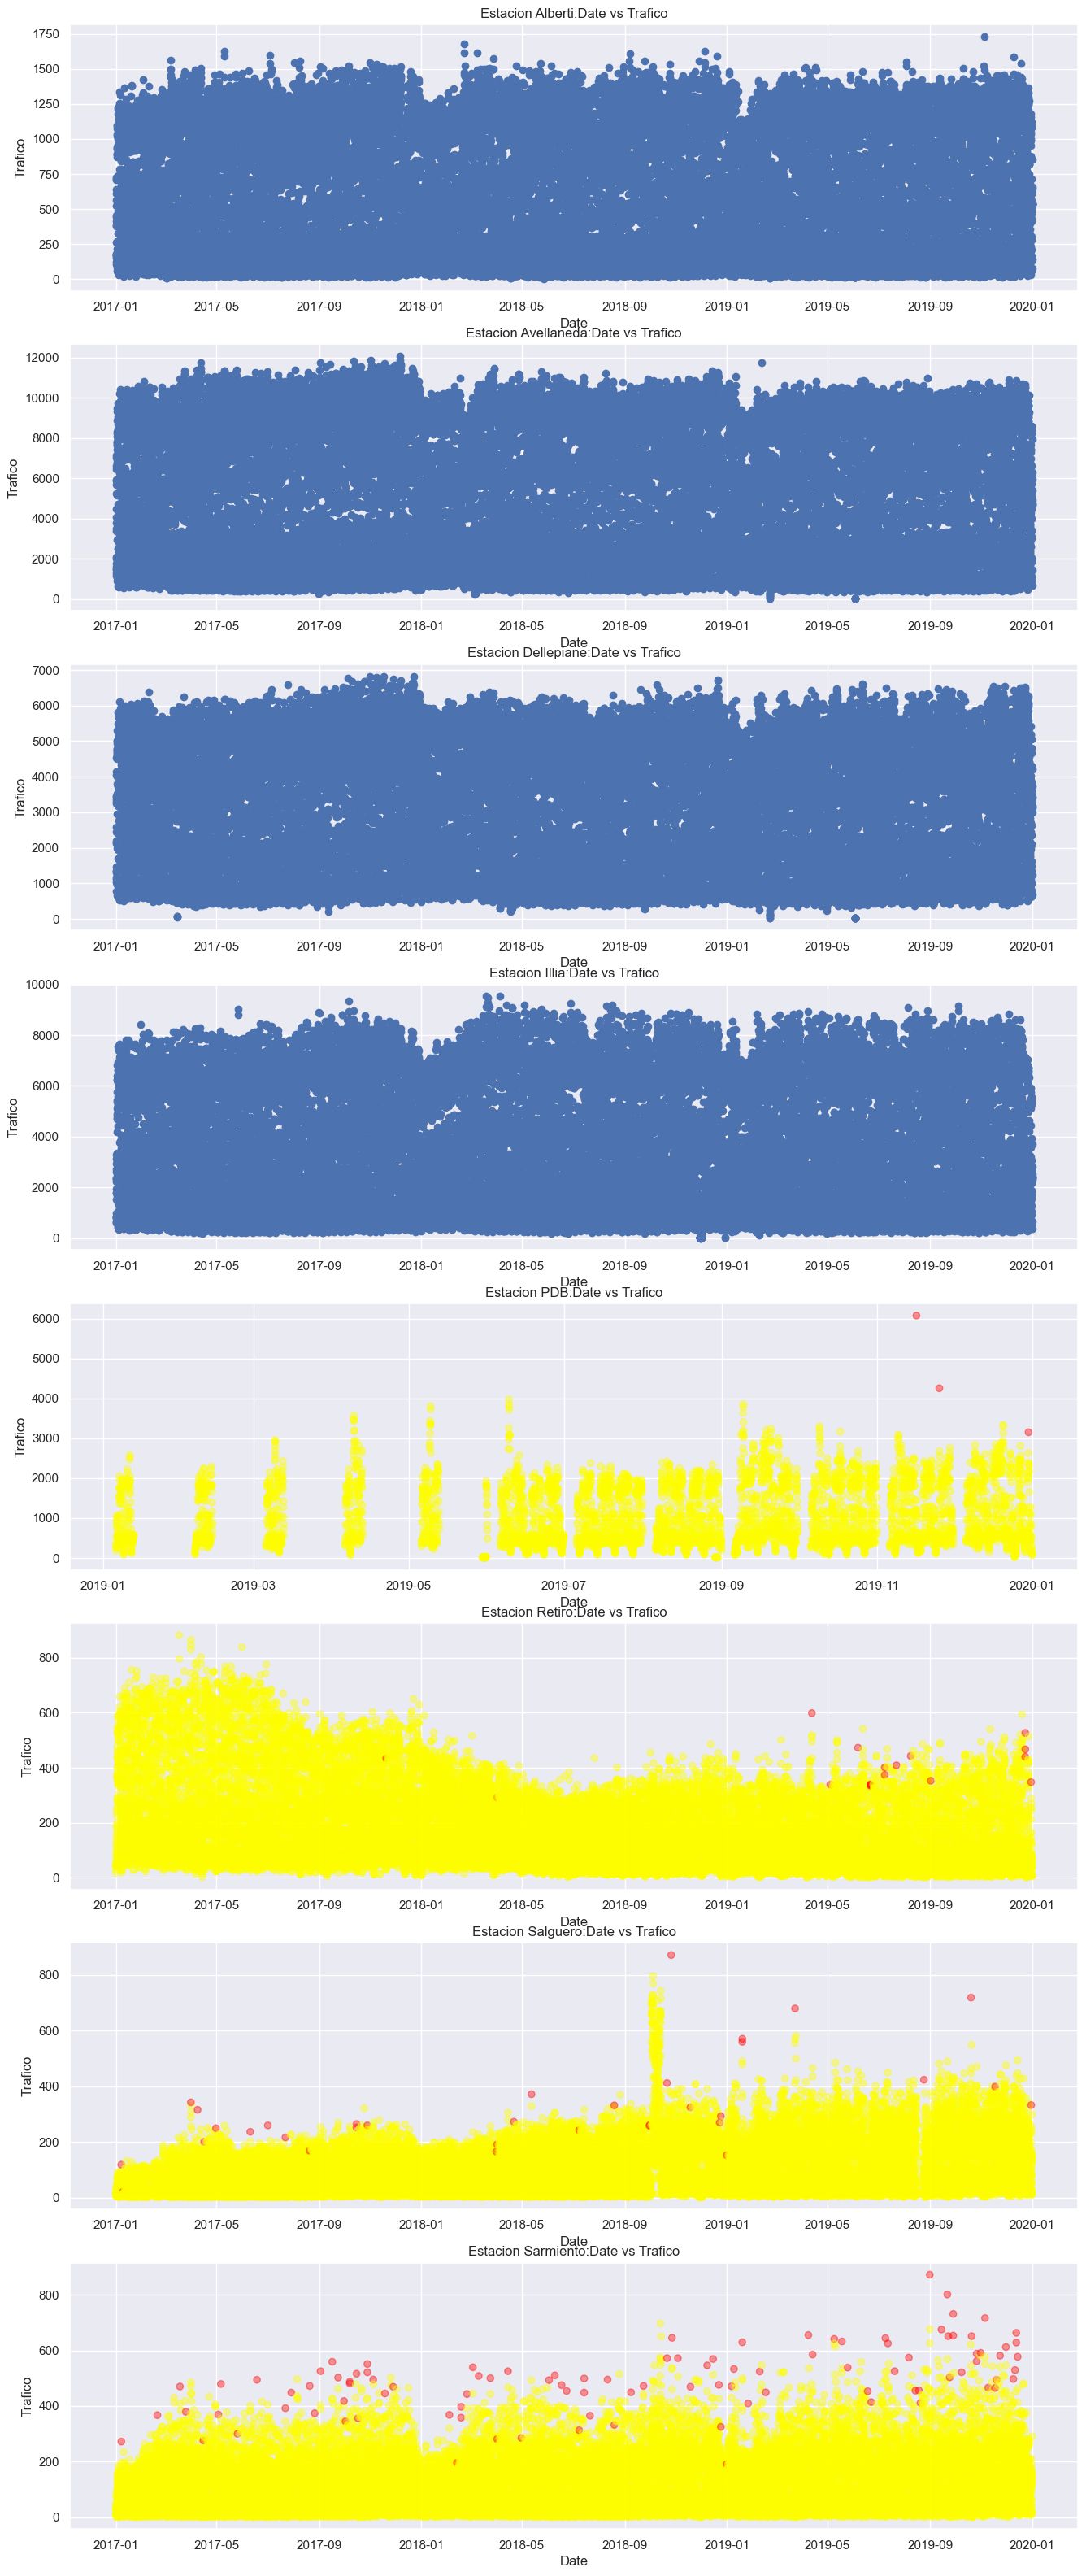

In [251]:
dfr,anomalies=plotoutliers_timeseries(df_analysis)

Outliers rappresentation


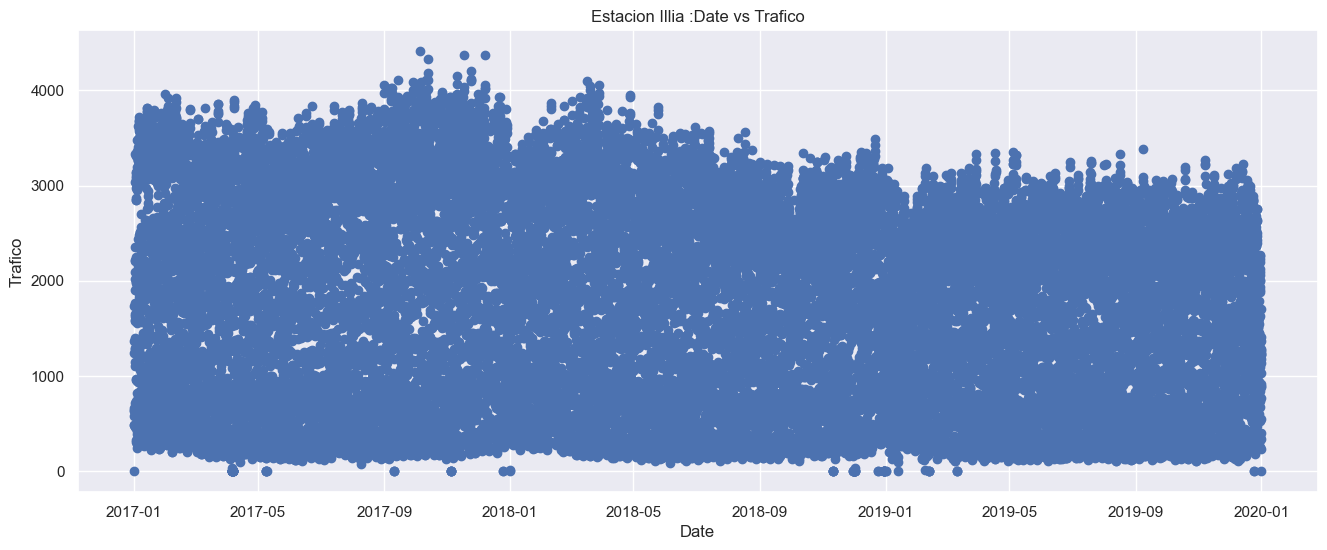

In [252]:
dfr2,anomalies2=plotoutliers_timeseries2(df_analysis2)

In [253]:
#not outliers for Illia df2v2

In [254]:
df1v2["anomalies"]=False
for key,value in anomalies.items():
    if len(value)>=1:
        for i in value:
            cond=(df1v2.estacion==key) & (df1v2.DateTime==i)
            df1v2.loc[cond,'anomalies'] = True

In [255]:
#Outliers
df1v2[df1v2.anomalies==True]

estacion  year  month  day       Date            DateTime  \
109331        PDB  2019     11   16 2019-11-16 2019-11-16 11:00:00   
109547        PDB  2019     11   25 2019-11-25 2019-11-25 11:00:00   
110268        PDB  2019     12   30 2019-12-30 2019-12-30 12:00:00   
118054     Retiro  2017     11   19 2017-11-19 2017-11-19 22:00:00   
121244     Retiro  2018      4    1 2018-04-01 2018-04-01 20:00:00   
...           ...   ...    ...  ...        ...                 ...   
187928  Sarmiento  2019     12    9 2019-12-09 2019-12-09 08:00:00   
187976  Sarmiento  2019     12   11 2019-12-11 2019-12-11 08:00:00   
188012  Sarmiento  2019     12   12 2019-12-12 2019-12-12 20:00:00   
188013  Sarmiento  2019     12   12 2019-12-12 2019-12-12 21:00:00   
188051  Sarmiento  2019     12   14 2019-12-14 2019-12-14 11:00:00   

        hora_inicio  cantidad_pasos  forma_pago_EFECTIVO  otras_forma_pago  \
109331           11          6075.0                  0.0          1.000000   
109547           11          4253.0                  0.0          1.000000   
110268           12          3150.0                  0.0          1.000000   
118054           22           434.0                  6.0          0.500000   
121244           20           292.0                  6.0          0.363636   
...             ...             ...                  ...               ...   
187928            8           497.0                  0.0          1.000000   
187976            8           529.0                  0.0          1.000000   
188012           20           663.0                  0.0          1.000000   
188013           21           628.0                  0.0          1.000000   
188051           11           577.0                  0.0          1.000000   

        anomalies  
109331       True  
109547       True  
110268       True  
118054       True  
121244       True  
...           ...  
187928       True  
187976       True  
188012       True  
188013       True  
188051       True  

[156 rows x 11 columns]

**Remoción e Imputación**

In [256]:
df1v3=df1v2.copy()

In [257]:
cond=(df1v3.anomalies==True) 
df1v3.loc[cond,'cantidad_pasos'] = np.nan
df1v3['cantidad_pasos'].interpolate(inplace=True)

In [258]:
df1v3['cantidad_pasos']=df1v3['cantidad_pasos'].round()

In [259]:
df1v3

estacion  year  month  day       Date            DateTime  \
0         Alberti  2017      1    1 2017-01-01 2017-01-01 00:00:00   
1         Alberti  2017      1    1 2017-01-01 2017-01-01 01:00:00   
2         Alberti  2017      1    1 2017-01-01 2017-01-01 02:00:00   
3         Alberti  2017      1    1 2017-01-01 2017-01-01 03:00:00   
4         Alberti  2017      1    1 2017-01-01 2017-01-01 04:00:00   
...           ...   ...    ...  ...        ...                 ...   
188467  Sarmiento  2019     12   31 2019-12-31 2019-12-31 19:00:00   
188468  Sarmiento  2019     12   31 2019-12-31 2019-12-31 20:00:00   
188469  Sarmiento  2019     12   31 2019-12-31 2019-12-31 21:00:00   
188470  Sarmiento  2019     12   31 2019-12-31 2019-12-31 22:00:00   
188471  Sarmiento  2019     12   31 2019-12-31 2019-12-31 23:00:00   

        hora_inicio  cantidad_pasos  forma_pago_EFECTIVO  otras_forma_pago  \
0                 0           104.0                  0.0          1.000000   
1                 1           613.0                  5.0          0.357143   
2                 2           640.0                  6.0          0.285714   
3                 3           380.0                  4.0          0.333333   
4                 4           168.0                  4.0          0.300000   
...             ...             ...                  ...               ...   
188467           19           163.0                  0.0          1.000000   
188468           20           291.0                  0.0          1.000000   
188469           21           159.0                  0.0          1.000000   
188470           22            18.0                  0.0          1.000000   
188471           23            14.0                  0.0          1.000000   

        anomalies  
0           False  
1           False  
2           False  
3           False  
4           False  
...           ...  
188467      False  
188468      False  
188469      False  
188470      False  
188471      False  

[188472 rows x 11 columns]

In [261]:
df1v3.to_csv(path+'/DatasetTotalEstaciones.csv') 

#### Componentes de la serie

Desde esta seccion se trataran solo los datos para la estacion Illia con pago en efectivo

In [262]:
newdf=df2v2.copy()
newdf.head(5)

year  month  day       Date            DateTime  hora_inicio  \
0  2017      1    1 2017-01-01 2017-01-01 00:00:00            0   
1  2017      1    1 2017-01-01 2017-01-01 01:00:00            1   
2  2017      1    1 2017-01-01 2017-01-01 02:00:00            2   
3  2017      1    1 2017-01-01 2017-01-01 03:00:00            3   
4  2017      1    1 2017-01-01 2017-01-01 04:00:00            4   

   cantidad_pasos  sentido_prov  vehiculo_liv  
0             1.0      0.000000      1.000000  
1          1374.0      0.500000      0.666667  
2          1734.0      0.500000      0.666667  
3          1247.0      0.428571      0.571429  
4           579.0      0.400000      0.800000

##### Modelo Aditivo

La serie temporal puede representarse como: $Y[t] = Tendencia[t] + Componente estacionaria[t] + Componente residual[t]$

In [263]:
from statsmodels.tsa.seasonal import seasonal_decompose

**Resampleo Diario**

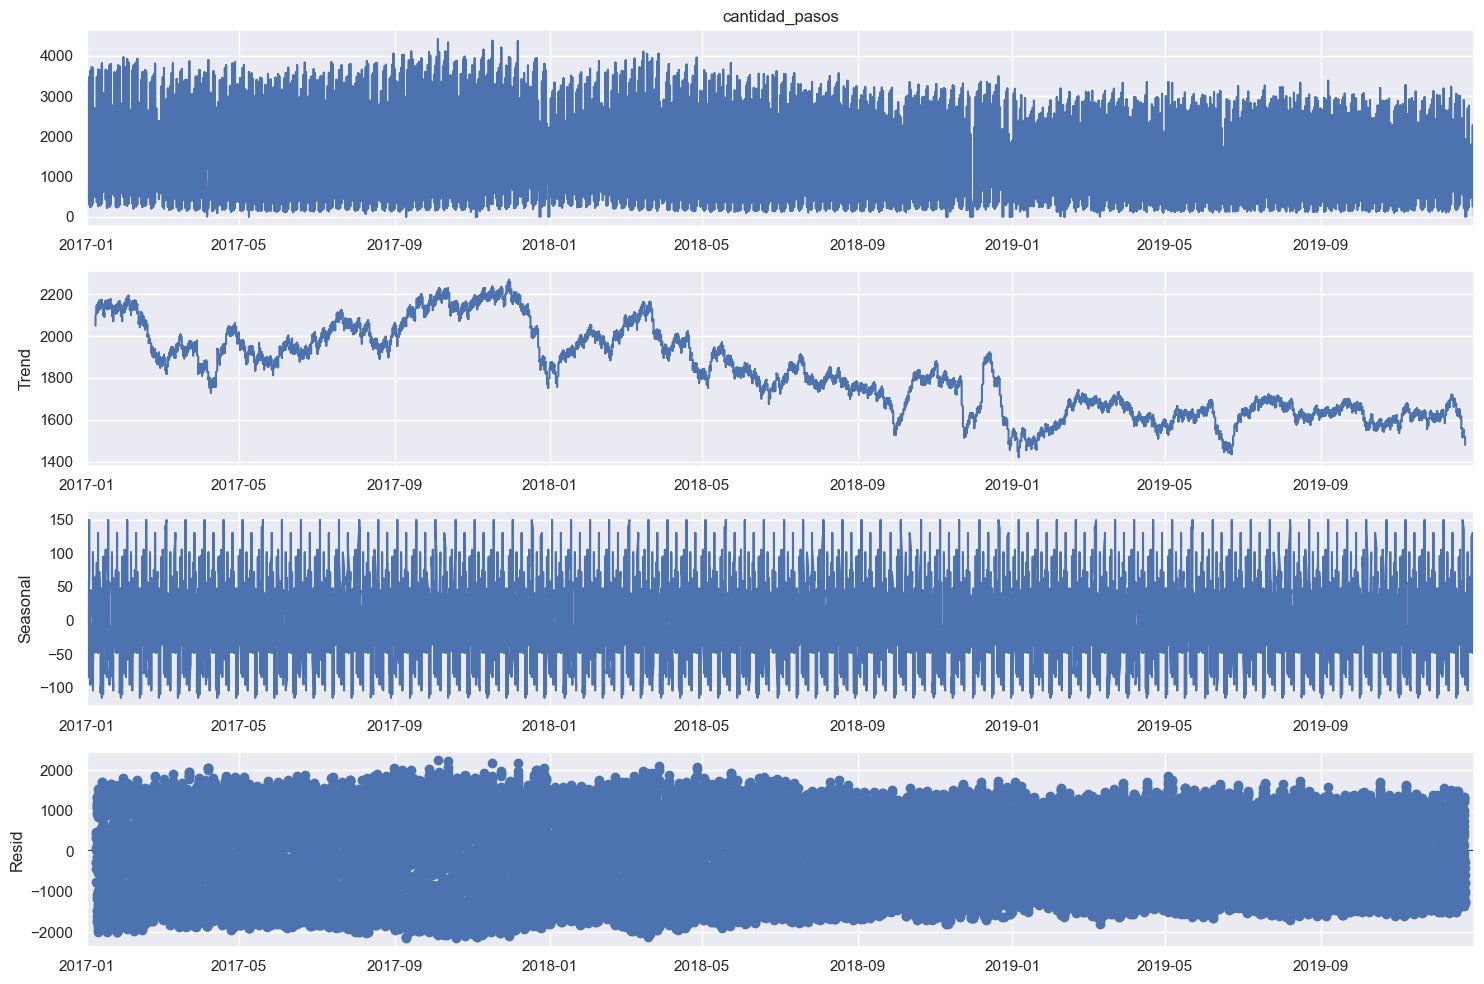

In [264]:
plt.rcParams['figure.figsize'] = [15,10]
result_additive = seasonal_decompose(newdf.set_index('Date').cantidad_pasos, period=365, model='additive')
result_additive.plot()
plt.show()

<AxesSubplot:xlabel='resid', ylabel='Density'>

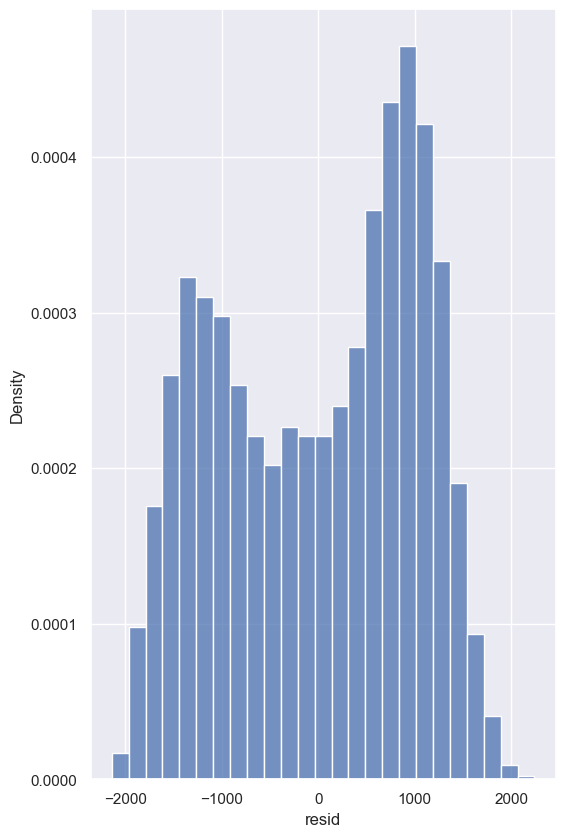

In [265]:
plt.figure(figsize=(6,10))
sns.histplot(result_additive.resid, stat= 'density', bins = 25, element='bars', fill=True)

**Resampleo Semanal**

In [266]:
dataset_analisis = newdf.groupby([pd.Grouper(key= 'Date',freq='W')]).sum()[['cantidad_pasos']]
dataset_analisis

cantidad_pasos
Date                      
2017-01-01         31183.0
2017-01-08        347212.0
2017-01-15        366413.0
2017-01-22        357215.0
2017-01-29        354581.0
...                    ...
2019-12-08        282891.0
2019-12-15        272960.0
2019-12-22        292881.0
2019-12-29        226398.0
2020-01-05         55970.0

[158 rows x 1 columns]

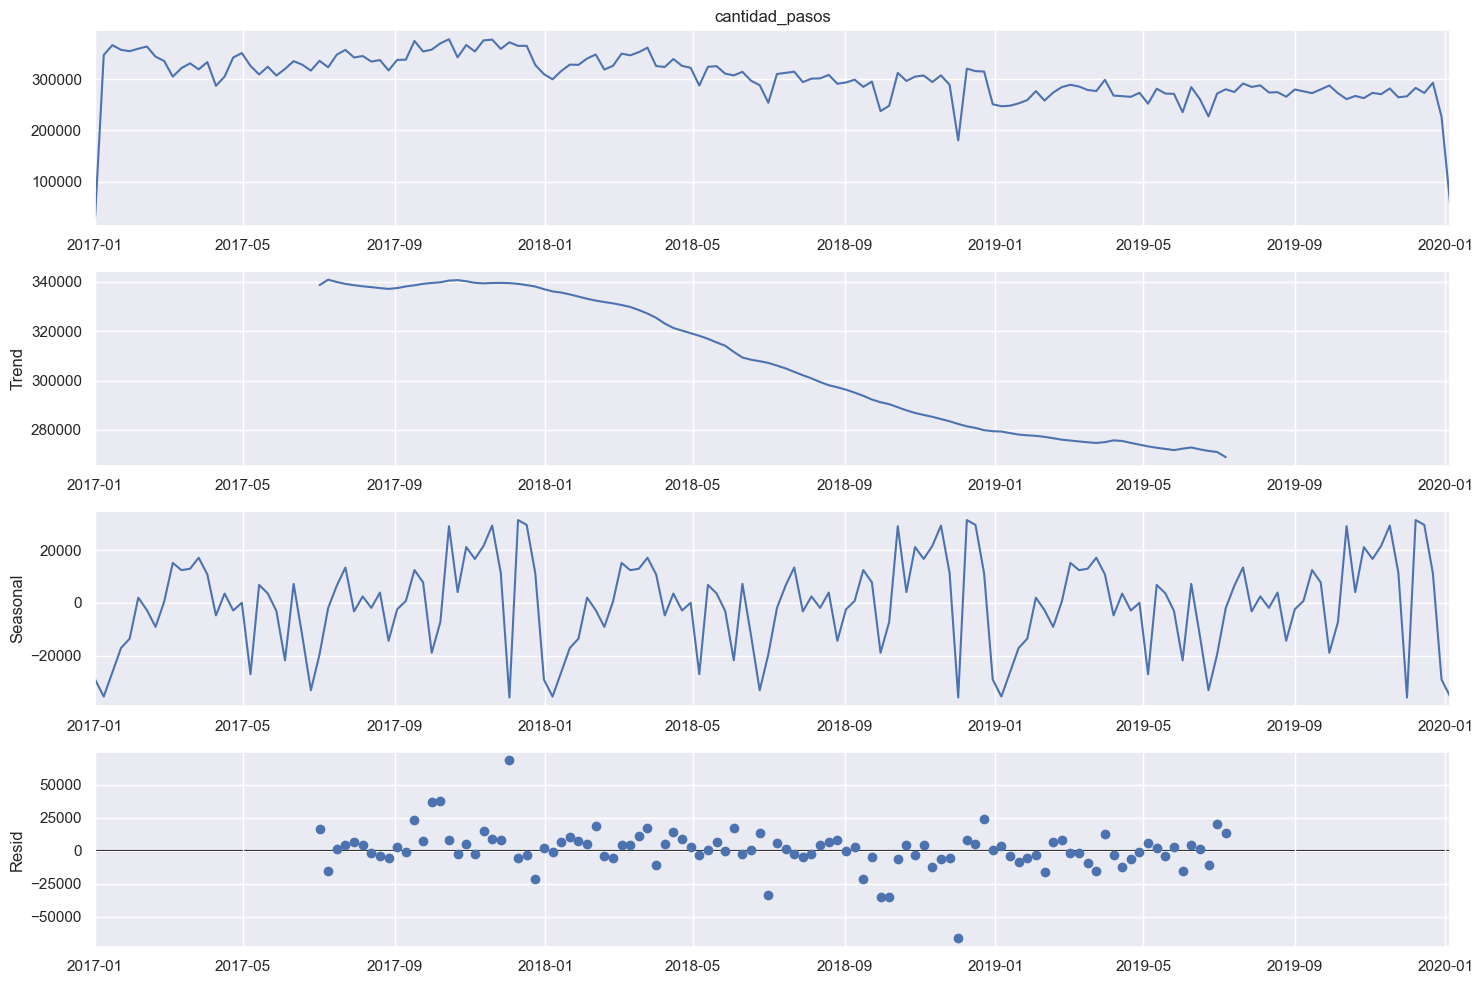

In [267]:
plt.rcParams['figure.figsize'] = [15,10]
#para Seasonal decomposition using moving averages.
result_additive = seasonal_decompose(dataset_analisis.cantidad_pasos,
                                     period=52, model='additive')
result_additive.plot()
plt.show()

<AxesSubplot:xlabel='resid', ylabel='Density'>

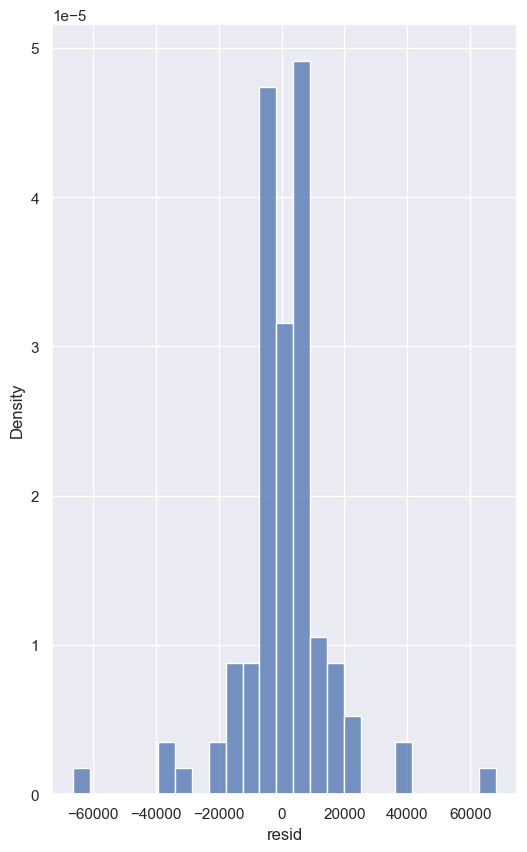

In [268]:
plt.figure(figsize=(6,10))
sns.histplot(result_additive.resid, stat= 'density', bins = 25, element='bars', fill=True)

Conclusion:
- Se observa que existe una tendencia negativa de la cantidad de pasos de peaje entre 2017 y 2019.
 
- Puede observarse que existe una componente estacional que tiende a incrementar desde los primeros meses del año hacia el fin de cada año. obsevable en la descomposición semanal de la serie. 
 
- Para el resampleo semanal, tanto en el gráfico de dispersión como en el histograma presentan una distribución aleatoria y homogénea de los residuos en torno del valor cero, valor sobre el cual deben distribuirse los residuos de un modelo de tipo aditivo. Esto sumado al hecho de que hay una gran concentracion de valores en valores residuales inferiores al 10% en relacion con la serie da un indicio de una buena aproximación del modelo bajo la representacion aditiva, esta ultima parte aplica tambien para el resampleo diario.

##### Modelo Multiplicativo

$Y[t] = Tendencia[t] * Componente estacionaria[t] * Componente residual[t]$

**Resampleo Diario**

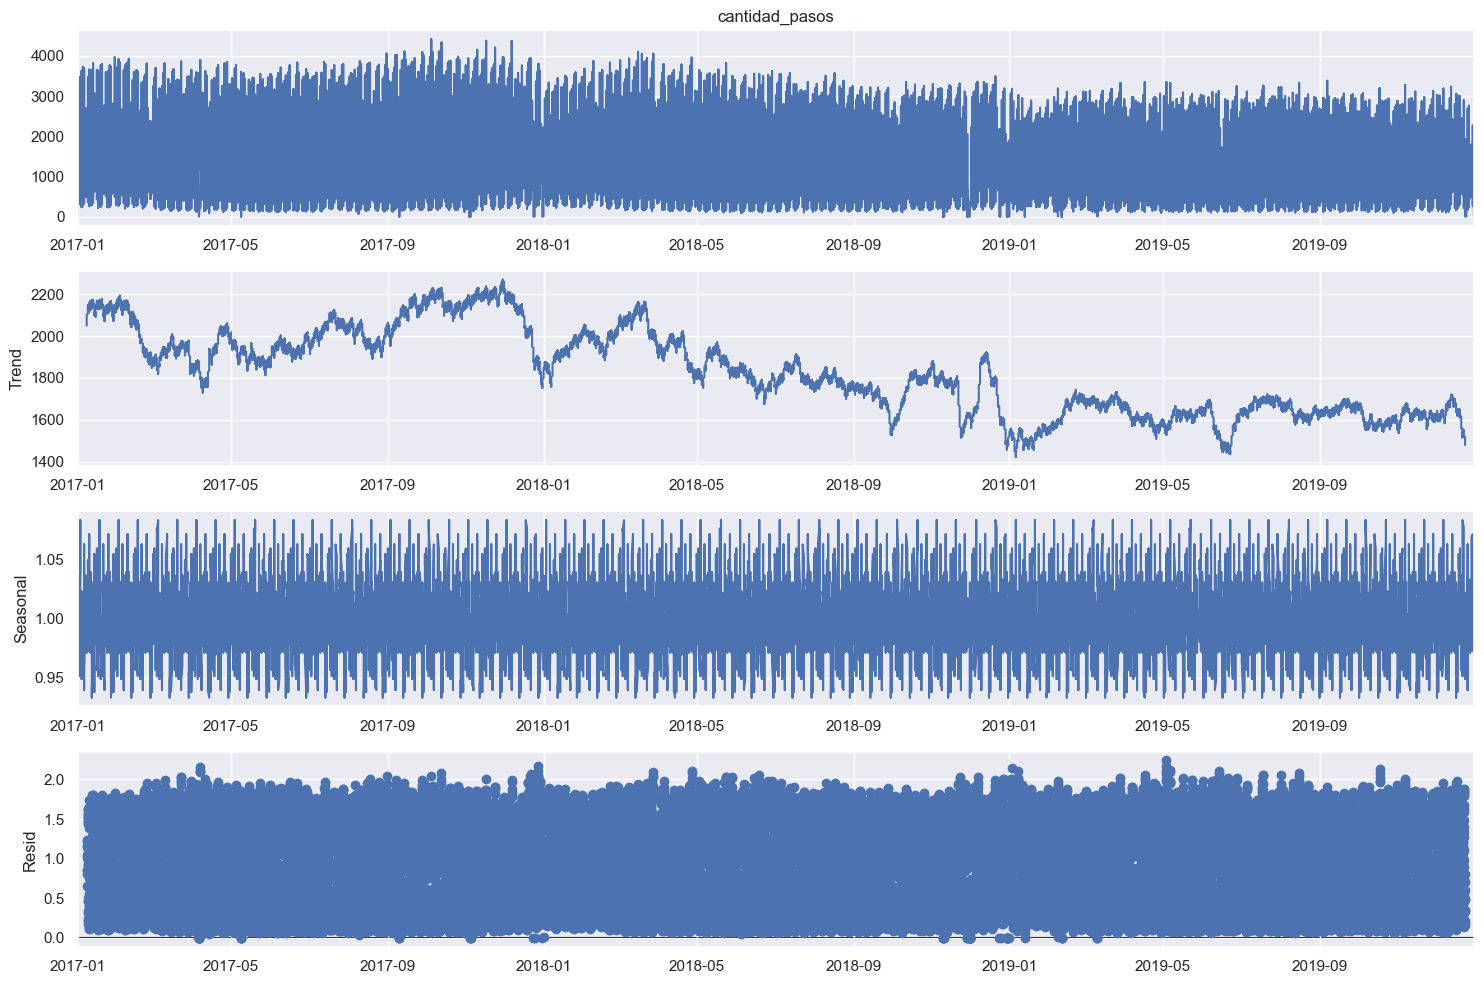

In [269]:
plt.rcParams['figure.figsize'] = [15,10]

#para Seasonal decomposition using moving averages.
result_multiplicative = seasonal_decompose(newdf.set_index('Date').cantidad_pasos,
                                     period=365, model='multiplicative')
result_multiplicative.plot()
plt.show()

<AxesSubplot:xlabel='resid', ylabel='Density'>

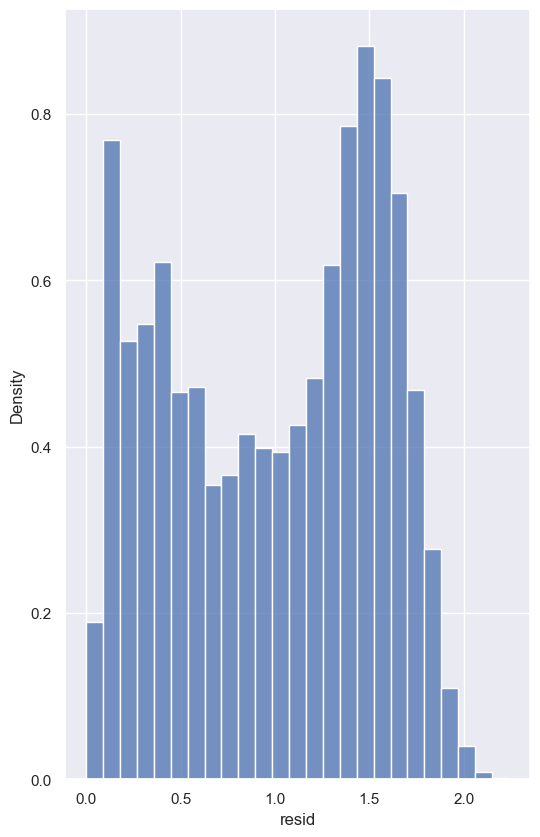

In [270]:
plt.figure(figsize=(6,10))
sns.histplot(result_multiplicative.resid, stat= 'density', bins = 25, element='bars', fill=True)

**Resampleo Semanal**

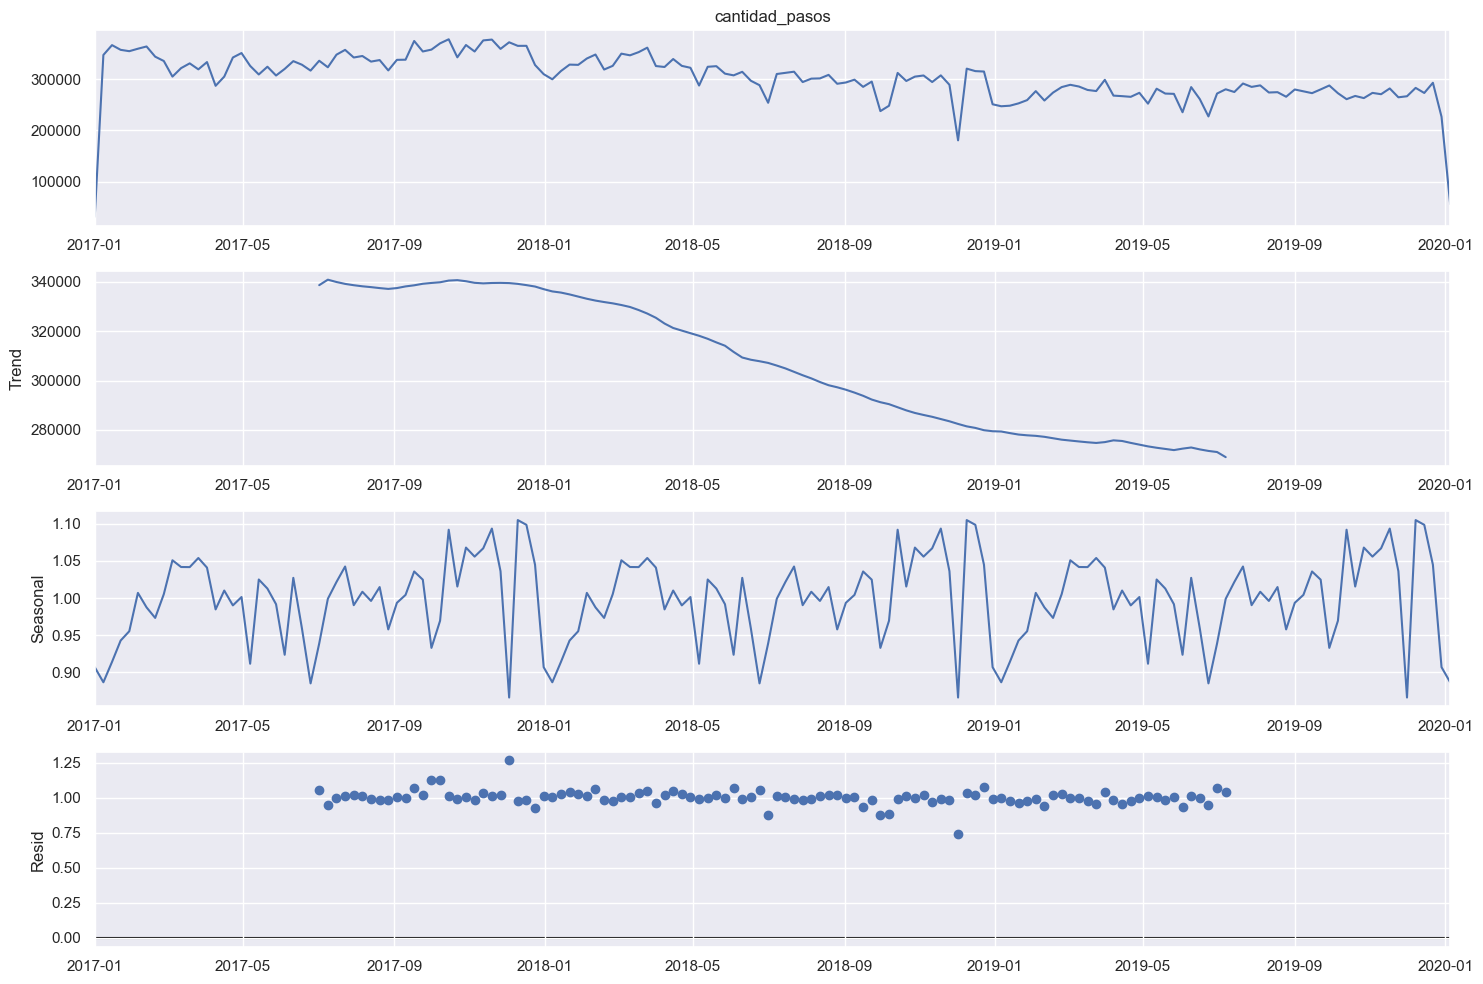

In [271]:
plt.rcParams['figure.figsize'] = [15,10]

#para Seasonal decomposition using moving averages.
result_multiplicative = seasonal_decompose(dataset_analisis.cantidad_pasos,
                                     period=52, model='multiplicative')
result_multiplicative.plot()
plt.show()

<AxesSubplot:xlabel='resid', ylabel='Density'>

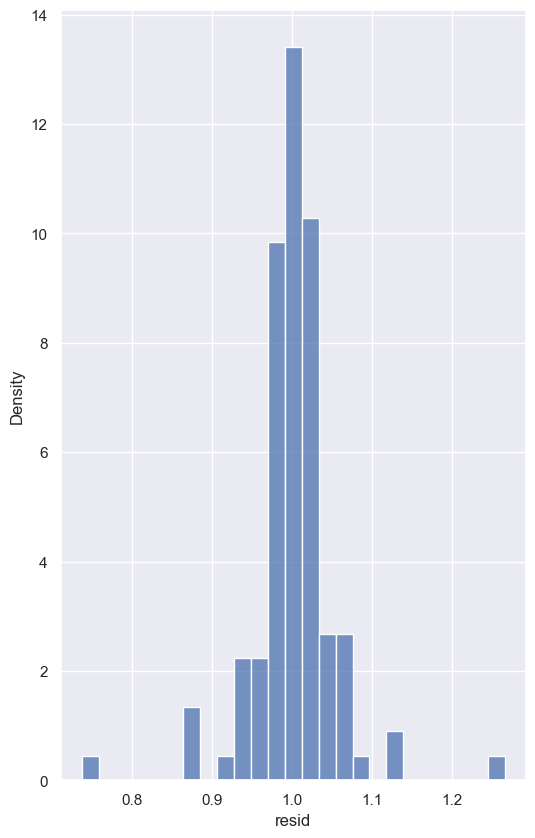

In [272]:
plt.figure(figsize=(6,10))
sns.histplot(result_multiplicative.resid, stat= 'density', bins = 25, element='bars', fill=True)

- Se mantienen las conclusiones para los componentes de la serie.
- Se agregara informacion-categorias auxiliares que podria ser necesaria como la estacion y la hora del dia
- Se contrastara respecto a los otros tipos de pago

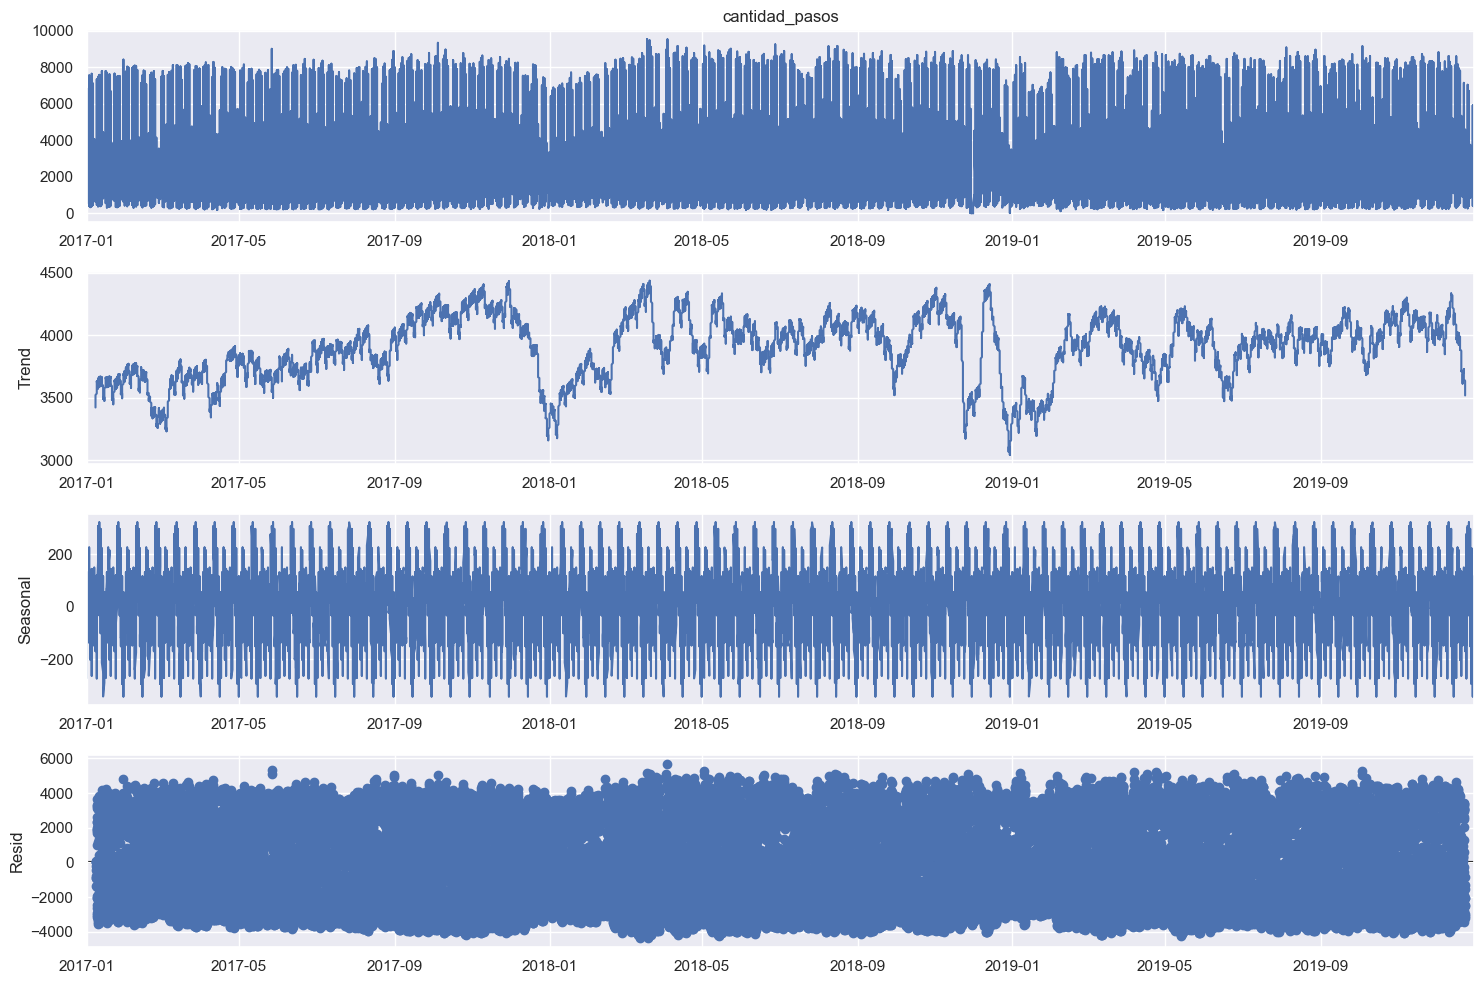

In [273]:
#diario
df1v5=df1v2[df1v2.estacion=="Illia"]
plt.rcParams['figure.figsize'] = [15,10]
result_additive = seasonal_decompose(df1v5.set_index('Date').cantidad_pasos, period=365, model='additive')
result_additive.plot()
plt.show()

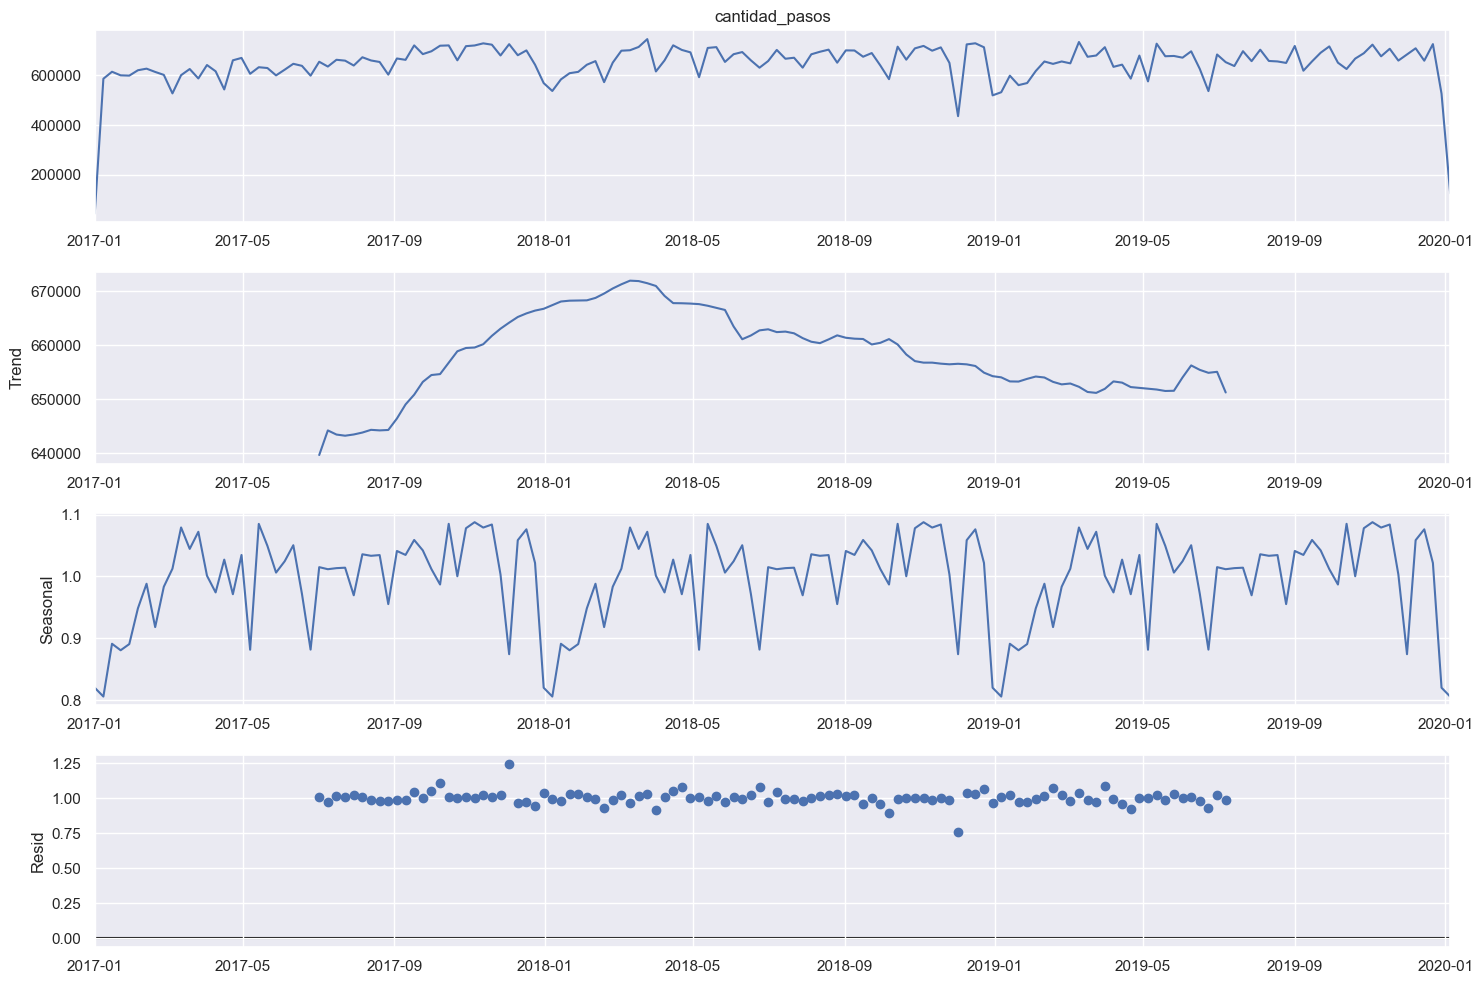

In [274]:
dataset_analisis5 = df1v5.groupby([pd.Grouper(key= 'Date',freq='W')]).sum()[['cantidad_pasos']]

plt.rcParams['figure.figsize'] = [15,10]

#para Seasonal decomposition using moving averages.
result_multiplicative = seasonal_decompose(dataset_analisis5.cantidad_pasos,
                                     period=52, model='multiplicative')
result_multiplicative.plot()
plt.show()

Se puede validar que la tendencia negativa se debe a que se migro a las otras dos fuentes de pagos de mayor presencia: TELEPASE y NO COBRADO

En el 1er trimestre del 2019 se encontro una tendencia negativa contraria al primer trimestre del 2017 y 2028, tambien faltaban 8 datos de fecha hasta el nivel hora, por lo que se imputaron interpolando y usando knnimputer, en un primer analisis usando el zscore par detectar outliers la data para la estacion de Illia con pago efectivo no presento outliers considerando una ventana de 24 horas para hallar la media y la desviacion standard, considerando hasta 3 desviaciones standard para la relacion entre el dato-media/std.

#### Nuevas Vars Predictoras

In [275]:
def season_calc(month):
    #https://seasonsyear.com/Argentina
    """considering months from December to February are denoted as 'summer' and months from June to February as 'winter'. """
    if month in [9,10,11]:
        return "Spring"
    elif month in [12,1,2]:
        return "Summer"
    elif month in [3,4,5]:
        return "Autumn"
    else:
        return "Winter"
    
def time_of_day(x):
    if x in hour_dict['morning']:
        return 'morning'
    elif x in hour_dict['afternoon']:
        return 'afternoon'
    elif x in hour_dict['evening']:
        return 'evening'
    else:
        return 'night'
    
dfr=df2v2.copy()
weekdays = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3: 'Thursday', 4: 'Friday', 5:'Saturday', 6:'Sunday'}
dfr['weekday'] = dfr.DateTime.dt.weekday.map(weekdays)
dfr['season'] = dfr.DateTime.dt.month.apply(season_calc)
#encaso de perder las columnas
dfr['year']=dfr.DateTime.dt.year
dfr['month']=dfr.DateTime.dt.month
dfr['day']=dfr.DateTime.dt.day
dfr['hour']=dfr.DateTime.dt.hour
dfr['Date'] = pd.to_datetime({'year':dfr.year, 'month': dfr.month, 'day': dfr.day})

start=dfr['Date'].min()
end = dfr['Date'].max()

#Feriados en Argentina
holidays_temp=[ (2,14),(3,24),(3,25),(3,27),(4,2),(5,1),(5,25),(6,20),(7,9),(8,17),(9,11),(10,7),(10,10),(10,31),(12,8),(12,11),(12,24),(12,31)]
years=dfr.year.unique()
holidays=[]
for a in holidays_temp:
    for year in years:
        x = datetime.date(year, a[0], a[1])
        if x>start and x<end:
            holidays.append(x)
            
#Adding holidays column to indicate whether a day was a holiday as per the argentinian calendar or not
dfr['holiday'] = dfr['Date'].isin(holidays)
#converting the holiday column to 1 and 0, 1 indicating a holiday and 0 not a holiday; using dictionary and map to achieve this
mapped = {True:1, False:0}
dfr.holiday = dfr.holiday.map(mapped)


#adding in another column which indicates 'non-working' days which include weekends and holidays
dfr['non_working'] = dfr.apply(lambda x: 'non-working' if \
                                         ((x['holiday'] == 1) or (x['weekday'] in ['Saturday', 'Sunday']))
                                         else 'working', axis = 1)

# Dividing the hours into 4 groups-> night, morning, afternoon, evening
hour_dict = {'morning': list(np.arange(7,13)),'afternoon': list(np.arange(13,16)), 'evening': list(np.arange(16,22)),
            'night': [22, 23, 0, 1, 2, 3, 4, 5, 6]}

dfr['time_of_day'] = dfr['hour'].apply(time_of_day)
dfr.head()

year  month  day       Date            DateTime  hora_inicio  \
0  2017      1    1 2017-01-01 2017-01-01 00:00:00            0   
1  2017      1    1 2017-01-01 2017-01-01 01:00:00            1   
2  2017      1    1 2017-01-01 2017-01-01 02:00:00            2   
3  2017      1    1 2017-01-01 2017-01-01 03:00:00            3   
4  2017      1    1 2017-01-01 2017-01-01 04:00:00            4   

   cantidad_pasos  sentido_prov  vehiculo_liv weekday  season  hour  holiday  \
0             1.0      0.000000      1.000000  Sunday  Summer     0        0   
1          1374.0      0.500000      0.666667  Sunday  Summer     1        0   
2          1734.0      0.500000      0.666667  Sunday  Summer     2        0   
3          1247.0      0.428571      0.571429  Sunday  Summer     3        0   
4           579.0      0.400000      0.800000  Sunday  Summer     4        0   

   non_working time_of_day  
0  non-working       night  
1  non-working       night  
2  non-working       night  
3  non-working       night  
4  non-working       night

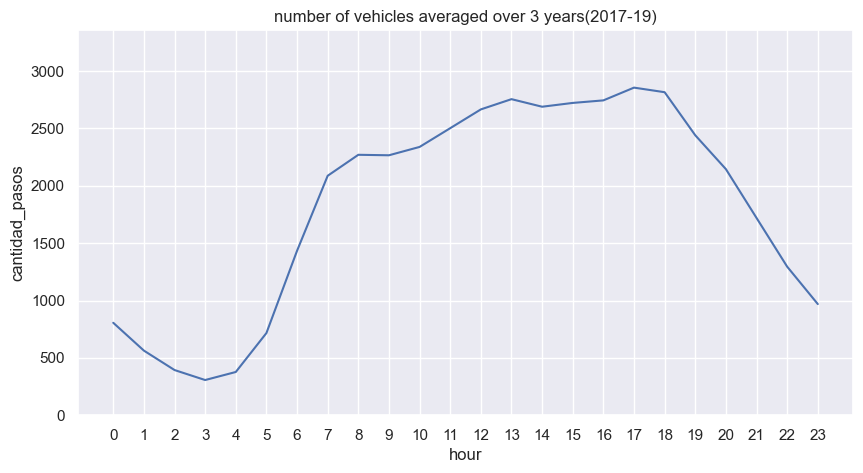

In [276]:
#Plotting average hourly load profile observed over the entire period 
dfr.groupby('hour')['cantidad_pasos'].mean().plot(figsize = (10,5))
_ = plt.ylabel('cantidad_pasos')
_ = plt.ylim([0, max(dfr.groupby('hour')['cantidad_pasos'].mean())+500])
_ = plt.xticks(dfr['hour'].unique())
_ = plt.title('number of vehicles averaged over 3 years(2017-19)')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


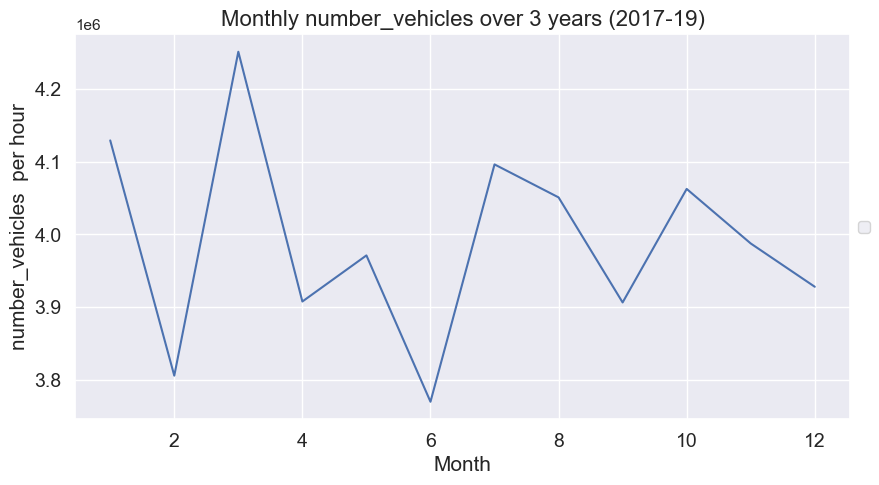

In [277]:
b=pd.DataFrame(dfr.groupby('month')['cantidad_pasos'].sum())
plt.figure(figsize=(10, 5))
sns.lineplot(data=b, x=b.index, y='cantidad_pasos')
plt.title('Monthly number_vehicles over 3 years (2017-19)',fontsize=16)
plt.xlabel('Month', fontsize=15)
plt.ylabel('number_vehicles  per hour', fontsize=15)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tick_params(labelsize=14)
plt.show()

Dado que la hora y el mes parecen explicar la variable dependiente se tomaran como categorias considerando las nuevas variables.

In [278]:
#Dataset
dfr.to_csv(path+'/timeseries_Illia_v1.csv')

### Predicción a Futuro

Objetivo:implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019.
La mayoria de las transformaciones se realizaron en la parte precedente, las siguientes seran necesarias para los modelos elegidos.

Metricas:

    Error cuadrático medio (MSE): media del cuadrado de las diferencias entre el valor actual y el valor predicho. Como particularidad penaliza más los errores más grandes y no se encuentra en la misma unidad del parámetro que mide sino en su unidad cuadrática.
- Raíz del error cuadrático medio (RMSE): es la raíz del error cuadrático medio. Tiene la ventaja de que se encuentra en las mismas unidades del parámetro en estudio lo que hace fácilmente comparable este valor como un parámetro de desviación. Sin embargo no se conoce si es grande o pequeño en relación al valor medido de manera inmediata.
- Error Absoluto medio (MAE): entrega la media de las diferencias absolutas entre el valor actual y el valor predicho. Penaliza de igual manera todos los errores y se encuentra en la misma unidad del parámetro que mide.
- Porcentaje del Error Absoluto medio (MAPE): entrega la media de las diferencias relativas entre el valor actual y el valor predicho. Permite obtener un valor porcentual de la desviación media relativa que tienen los valores conociendo de entrada si es grande o pequeño en relación al valor de referencia. Quizá sea la métrica de error más simple de transmitir al negocio o clientes por tratarse un valor porcentual de desviación.
- R2 score(R2): Mide el porcentaje de la variance en las predicciones explicado por el dataset, es la diferencia de las muestras en el dataset y en la prediccion del modelo.


In [171]:
#functions:

# function for plot predicted vs actual values
def plot_predvstrue_reg(pred, truth, model_name=None):
    """
    Plots the observed number of vehicles against the predicted values
    """
    fig, ax = plt.subplots(1,1, figsize=(8,8))
    ax.scatter(truth, pred) 
    _ = plt.xlabel("Observed number of vehicles")
    _ = plt.ylabel("Predicted number of vehicles")
    _ = plt.title("Observed vs Predicted number of vehicles with model: {}".format(model_name))
    _ = plt.xlim(0, 5000)
    _ = plt.ylim(0, 5000)
    #plotting 45 deg line to see how the prediction differs from the observed values
    x = np.linspace(*ax.get_xlim())
    _ = ax.plot(x, x)


# Creating an empty dict to save all the erros from different models

def error_metrics(y_pred, y_truth, model_name = None, test = True):
    """
    Printing error metrics like RMSE (root mean square error), R2 score, 
    MAE (mean absolute error), MAPE (mean absolute % error). 
    
    y_pred: predicted values of y using the model model_name
    y_truth: observed values of y
    model_name: name of the model used for predictions
    test: if validating on test set, True; otherwise False for training set validation
    
    The function will print the RMSE, R2, MAE and MAPE error metrics for the model_name and also store the results along with 
    model_name in the dictionary dict_error so that we can compare all the models at the end.
    """
    dict_error = dict()
    if isinstance(y_pred, np.ndarray):
        y_pred = y_pred
    else:
        y_pred = y_pred.to_numpy()
        
    if isinstance(y_truth, np.ndarray):
        y_truth = y_truth
    else:
        y_truth = y_truth.to_numpy()
          
    RMSE = np.sqrt(mean_squared_error(y_truth, y_pred))   
    # Explained variance score: 1 is perfect prediction

    R2 = r2_score(y_truth, y_pred)
    MAE = mean_absolute_error(y_truth, y_pred)
    MAPE = (np.mean(np.abs((y_truth - y_pred) / y_truth)) * 100)
    
    # Appending the error values along with the model_name to the dict
    if test:
        train_test = 'test'
    else:
        train_test = 'train'
    
    #df = pd.DataFrame({'model': model_name, 'RMSE':RMSE, 'R2':R2, 'MAE':MAE, 'MAPE':MAPE}, index=[0])
    name_error = ['model', 'train_test', 'RMSE', 'R2', 'MAE', 'MAPE']
    value_error = [model_name, train_test, RMSE, R2, MAE, MAPE]
    list_error = list(zip(name_error, value_error))
    
    for error in list_error:
        if error[0] in dict_error:
            # append the new number to the existing array at this slot
            dict_error[error[0]].append(error[1])
        else:
            dict_error[error[0]] = error[1]
    return(dict_error)

def plot_ts_pred(og_ts, pred_ts, model_name=None, og_ts_opacity = 0.5, pred_ts_opacity = 0.5):
    """
    Plot plotly time series of the original (og_ts) and predicted (pred_ts) time series values to check how our model performs.
    model_name: name of the model used for predictions
    og_ts_opacity: opacity of the original time series
    pred_ts_opacity: opacity of the predicted time series
    """
    
    fig = go.Figure()

    fig.add_trace(go.Scatter(x = og_ts.index, y = np.array(og_ts.values), name = "Observed",
                         line_color = 'deepskyblue', opacity = og_ts_opacity))

    try:
        fig.add_trace(go.Scatter(x = pred_ts.index, y = pred_ts, name = model_name,
                         line_color = 'lightslategrey', opacity = pred_ts_opacity))
    except: #if predicted values are a numpy array they won't have an index
        fig.add_trace(go.Scatter(x = og_ts.index, y = pred_ts, name = model_name,
                         line_color = 'lightslategrey', opacity = pred_ts_opacity))


    #fig.add_trace(go)
    fig.update_layout(title_text = 'Observed test set vs predicted number of vehicles  using {}'.format(model_name),
                  xaxis_rangeslider_visible = True)
    fig.show()

In [172]:
dfload=pd.read_csv(path+'/timeseries_Illia_v1.csv',index_col = [0], parse_dates=['Date','DateTime'])
dfload['date_number_ordinal']=dfload.DateTime.map(datetime.datetime.toordinal)
digits=2
num1 = dfload.date_number_ordinal * (10**digits)
num1 += dfload.hour
dfload['date_number_ordinal1']=num1
dfload.head()

year  month  day       Date            DateTime  hora_inicio  \
0  2017      1    1 2017-01-01 2017-01-01 00:00:00            0   
1  2017      1    1 2017-01-01 2017-01-01 01:00:00            1   
2  2017      1    1 2017-01-01 2017-01-01 02:00:00            2   
3  2017      1    1 2017-01-01 2017-01-01 03:00:00            3   
4  2017      1    1 2017-01-01 2017-01-01 04:00:00            4   

   cantidad_pasos  sentido_prov  vehiculo_liv weekday  season  hour  holiday  \
0             1.0      0.000000      1.000000  Sunday  Summer     0        0   
1          1374.0      0.500000      0.666667  Sunday  Summer     1        0   
2          1734.0      0.500000      0.666667  Sunday  Summer     2        0   
3          1247.0      0.428571      0.571429  Sunday  Summer     3        0   
4           579.0      0.400000      0.800000  Sunday  Summer     4        0   

   non_working time_of_day  date_number_ordinal  date_number_ordinal1  
0  non-working       night               736330              73633000  
1  non-working       night               736330              73633001  
2  non-working       night               736330              73633002  
3  non-working       night               736330              73633003  
4  non-working       night               736330              73633004

In [173]:
# creating categorical columns for linear regression 
cat_cols = ['season', 'weekday','holiday', 'non_working','time_of_day']

for col in cat_cols:
    dfload[col] = dfload[col].astype('category')
    
cols_use = ['cantidad_pasos', 'date_number_ordinal1','Date','DateTime','time_of_day','season', 'non_working','weekday','holiday'
               ,'lag1','sentido_prov','vehiculo_liv']
 
def customize_df(df,x):
        #  lag1 is the value of the number of vehicles  in previous hour
        #  lag2 is the value of the number of vehicles in the hour before previous hour and so on...\"\"\"\n",
    for i in range(x):
        df['lag'+str(i+1)] = df['cantidad_pasos'].shift(i+1)
        # Since the first x values won't have any xth lag, they will be NaN. So dropping the NaNs\n",
    df.dropna(inplace= True)
    df.reset_index(drop=True, inplace=True)
    df = pd.get_dummies(df[cols_use])
    return df

df_lags=customize_df(dfload,1)
df_lags.head(10)

cantidad_pasos  date_number_ordinal1       Date            DateTime  \
0          1374.0              73633001 2017-01-01 2017-01-01 01:00:00   
1          1734.0              73633002 2017-01-01 2017-01-01 02:00:00   
2          1247.0              73633003 2017-01-01 2017-01-01 03:00:00   
3           579.0              73633004 2017-01-01 2017-01-01 04:00:00   
4           645.0              73633005 2017-01-01 2017-01-01 05:00:00   
5           665.0              73633006 2017-01-01 2017-01-01 06:00:00   
6           635.0              73633007 2017-01-01 2017-01-01 07:00:00   
7           482.0              73633008 2017-01-01 2017-01-01 08:00:00   
8           485.0              73633009 2017-01-01 2017-01-01 09:00:00   
9           718.0              73633010 2017-01-01 2017-01-01 10:00:00   

     lag1  sentido_prov  vehiculo_liv  time_of_day_afternoon  \
0     1.0      0.500000      0.666667                      0   
1  1374.0      0.500000      0.666667                      0   
2  1734.0      0.428571      0.571429                      0   
3  1247.0      0.400000      0.800000                      0   
4   579.0      0.571429      0.571429                      0   
5   645.0      0.333333      0.444444                      0   
6   665.0      0.250000      0.500000                      0   
7   635.0      0.454545      0.363636                      0   
8   482.0      0.416667      0.333333                      0   
9   485.0      0.500000      0.400000                      0   

   time_of_day_evening  time_of_day_morning  ...  non_working_working  \
0                    0                    0  ...                    0   
1                    0                    0  ...                    0   
2                    0                    0  ...                    0   
3                    0                    0  ...                    0   
4                    0                    0  ...                    0   
5                    0                    0  ...                    0   
6                    0                    1  ...                    0   
7                    0                    1  ...                    0   
8                    0                    1  ...                    0   
9                    0                    1  ...                    0   

   weekday_Friday  weekday_Monday  weekday_Saturday  weekday_Sunday  \
0               0               0                 0               1   
1               0               0                 0               1   
2               0               0                 0               1   
3               0               0                 0               1   
4               0               0                 0               1   
5               0               0                 0               1   
6               0               0                 0               1   
7               0               0                 0               1   
8               0               0                 0               1   
9               0               0                 0               1   

   weekday_Thursday  weekday_Tuesday  weekday_Wednesday  holiday_0  holiday_1  
0                 0                0                  0          1          0  
1                 0                0                  0          1          0  
2                 0                0                  0          1          0  
3                 0                0                  0          1          0  
4                 0                0                  0          1          0  
5                 0                0                  0          1          0  
6                 0                0                  0          1          0  
7                 0                0                  0          1          0  
8                 0                0                  0          1          0  
9                 0                0                  0          1          0  

[10 rows x 26 co

In [174]:
df_lags.columns
df_lags.to_csv(path+'/timeseries_Illia_fullcolumns.csv')

In [175]:
df1_lags=df_lags[['cantidad_pasos', 'date_number_ordinal1', 'Date', 'DateTime', 'lag1',
       'sentido_prov', 'vehiculo_liv', 'time_of_day_afternoon',
       'time_of_day_evening', 'time_of_day_morning', 'time_of_day_night',
       'season_Autumn', 'season_Spring', 'season_Summer', 'season_Winter',
       'non_working_non-working', 'non_working_working', 'weekday_Friday',
       'weekday_Monday', 'weekday_Saturday', 'weekday_Sunday',
       'weekday_Thursday', 'weekday_Tuesday', 'weekday_Wednesday', 'holiday_0',
       'holiday_1']].set_index('DateTime')

In [176]:
dfload['cantidad_pasos'].corr(dfload['cantidad_pasos'].shift(1))

0.9344213590576458

In [177]:
#Ultimo trimestre 2019 oct,nov,dic
test_df = df1_lags[(df1_lags.Date<="2019-12-31")&(df1_lags.Date>="2019-10-01")]
train_df = df1_lags[(df1_lags.Date<"2019-10-01")]
X_test=test_df.drop(["cantidad_pasos",'Date'], axis = 1)
X_train=train_df.drop(["cantidad_pasos",'Date'], axis = 1)
y_test = test_df.cantidad_pasos
y_train = train_df.cantidad_pasos

In [178]:
test_df.head(10)

cantidad_pasos  date_number_ordinal1       Date    lag1  \
DateTime                                                                       
2019-10-01 00:00:00           657.0              73733300 2019-10-01   535.0   
2019-10-01 01:00:00           387.0              73733301 2019-10-01   657.0   
2019-10-01 02:00:00           292.0              73733302 2019-10-01   387.0   
2019-10-01 03:00:00           269.0              73733303 2019-10-01   292.0   
2019-10-01 04:00:00           379.0              73733304 2019-10-01   269.0   
2019-10-01 05:00:00           709.0              73733305 2019-10-01   379.0   
2019-10-01 06:00:00          1497.0              73733306 2019-10-01   709.0   
2019-10-01 07:00:00          2069.0              73733307 2019-10-01  1497.0   
2019-10-01 08:00:00          2307.0              73733308 2019-10-01  2069.0   
2019-10-01 09:00:00          2306.0              73733309 2019-10-01  2307.0   

                     sentido_prov  vehiculo_liv  time_of_day_afternoon  \
DateTime                                                                 
2019-10-01 00:00:00           0.5           0.5                      0   
2019-10-01 01:00:00           0.5           0.5                      0   
2019-10-01 02:00:00           0.5           0.5                      0   
2019-10-01 03:00:00           0.5           0.5                      0   
2019-10-01 04:00:00           0.5           0.5                      0   
2019-10-01 05:00:00           0.5           0.5                      0   
2019-10-01 06:00:00           0.5           0.5                      0   
2019-10-01 07:00:00           0.5           0.5                      0   
2019-10-01 08:00:00           0.5           0.5                      0   
2019-10-01 09:00:00           0.5           0.5                      0   

                     time_of_day_evening  time_of_day_morning  \
DateTime                                                        
2019-10-01 00:00:00                    0                    0   
2019-10-01 01:00:00                    0                    0   
2019-10-01 02:00:00                    0                    0   
2019-10-01 03:00:00                    0                    0   
2019-10-01 04:00:00                    0                    0   
2019-10-01 05:00:00                    0                    0   
2019-10-01 06:00:00                    0                    0   
2019-10-01 07:00:00                    0                    1   
2019-10-01 08:00:00                    0                    1   
2019-10-01 09:00:00                    0                    1   

                     time_of_day_night  ...  non_working_working  \
DateTime                                ...                        
2019-10-01 00:00:00                  1  ...                    1   
2019-10-01 01:00:00                  1  ...                    1   
2019-10-01 02:00:00                  1  ...                    1   
2019-10-01 03:00:00                  1  ...                    1   
2019-10-01 04:00:00                  1  ...                    1   
2019-10-01 05:00:00                  1  ...                    1   
2019-10-01 06:00:00                  1  ...                    1   
2019-10-01 07:00:00                  0  ...                    1   
2019-10-01 08:00:00                  0  ...                    1   
2019-10-01 09:00:00                  0  ...                    1   

                     weekday_Friday  weekday_Monday  weekday_Saturday  \
DateTime                                                                
2019-10-01 00:00:00               0               0                 0   
2019-10-01 01:00:00               0               0                 0   
2019-10-01 02:00:00               0               0                 0   
2019-10-01 03:00:00               0               0                 0   
2019-10-01 04:00:00               0               0                 0   
2019-10-01 05:00:00               0               0           

#### Benchmark: Linear Regression

In [179]:
# LinearRegression object
lm = LinearRegression()
# Fitting the linear regression model
lm.fit(X_train, y_train)

LinearRegression()

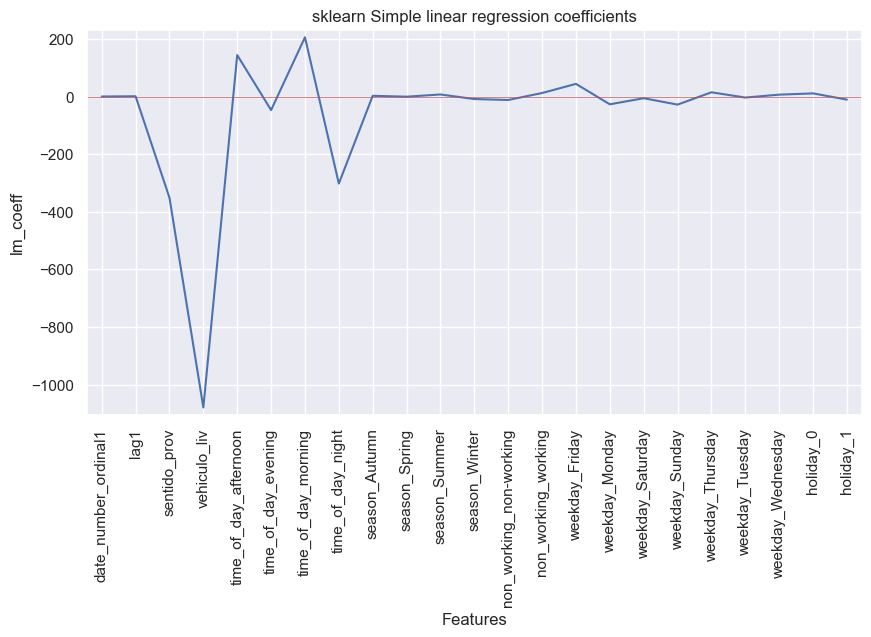

In [180]:
# Ploting the coefficients
_ = plt.figure(figsize = (10, 5))
_ = plt.plot(range(len(X_train.columns)), lm.coef_)
_ = plt.xticks(range(len(X_train.columns)), X_train.columns.values, rotation = 90)
_ = plt.margins(0.02)
_ = plt.axhline(0, linewidth = 0.5, color = 'r')
_ = plt.title('sklearn Simple linear regression coefficients')
_ = plt.ylabel('lm_coeff')
_ = plt.xlabel('Features')

Los parametros:
- date_number_ordinal1: fue armado con el valor numerico de date y concatenando con la hora, entonces tiene un significado categorico
- vehiculo_liv: el valor es demasiado negativo podria portar a valores imposibles y limites para el trafico
- almenos un time debe retirarse dado que no se puede tener a todos los elementos de la misma clase como variables predictoras, se retira "evening"
- para season se retira todas menos summer
- se quita non_working_non-working, el indicador para los dias laborables ( se busca que la variable dependiente sea positiva)
- se presciende de el dia tuesday y saturday
- se presciende de el indicador para dias feriados ( se busca que la variable dependiente sea positiva)

In [181]:
df2_lags=df_lags[['cantidad_pasos', 'Date', 'DateTime', 'lag1',
       'sentido_prov', 'time_of_day_afternoon',
       'time_of_day_morning', 'time_of_day_night',
       'season_Summer', 
       'non_working_working', 'weekday_Friday',
       'weekday_Monday', 'weekday_Sunday',
       'weekday_Thursday', 'weekday_Wednesday',
       'holiday_1']].set_index('DateTime')

#Ultimo trimestre 2019 oct,nov,dic
test_df = df1_lags[(df1_lags.Date<="2019-12-31")&(df1_lags.Date>="2019-10-01")]
train_df = df1_lags[(df1_lags.Date<"2019-10-01")]
X_test=test_df.drop(["cantidad_pasos",'Date'], axis = 1)
X_train=train_df.drop(["cantidad_pasos",'Date'], axis = 1)
y_test = test_df.cantidad_pasos
y_train = train_df.cantidad_pasos

# LinearRegression object
lm = LinearRegression()
# Fitting the linear regression model
lm.fit(X_train, y_train)

LinearRegression()

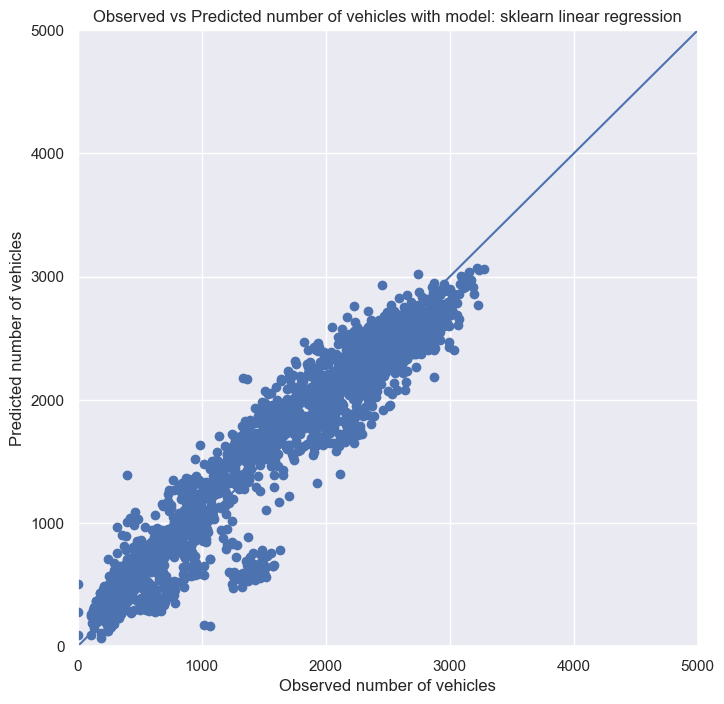

In [182]:
plot_predvstrue_reg(lm.predict(X_test), y_test, model_name = 'sklearn linear regression')

In [183]:
#In TRAIN and test
error1=error_metrics(lm.predict(X_train), y_train, model_name = 'linear regression', test = False)
error2=error_metrics(lm.predict(X_test), y_test, model_name = 'linear regression', test = True)

cols=["label","value"]
results = pd.DataFrame(list(error1.items()),columns = cols) 
results2=pd.DataFrame(error2.items(),columns=cols)
resultdf=results.merge(results2,how="left",on="label")
resultdf

label            value_x            value_y
0       model  linear regression  linear regression
1  train_test              train               test
2        RMSE         324.322668         267.104865
3          R2           0.902616           0.904319
4         MAE         245.126924         205.767745
5        MAPE          65.564289          31.018962

In [184]:
#Prediccion para el ultimo trimestre por hora
result=test_df[["cantidad_pasos"]]
result["ypred"]=lm.predict(X_test)
result.head(10)

cantidad_pasos        ypred
DateTime                                        
2019-10-01 00:00:00           657.0   539.617351
2019-10-01 01:00:00           387.0   632.846220
2019-10-01 02:00:00           292.0   426.523900
2019-10-01 03:00:00           269.0   353.929789
2019-10-01 04:00:00           379.0   336.355285
2019-10-01 05:00:00           709.0   420.414219
2019-10-01 06:00:00          1497.0   672.588617
2019-10-01 07:00:00          2069.0  1782.382800
2019-10-01 08:00:00          2307.0  2219.484207
2019-10-01 09:00:00          2306.0  2401.355775

#### Modelo: XGBoost
- **múltiples parámetros:** se estima la cantidad de vehículos a partir de todos los parámetros de estudio con que cuenta el dataset.
- **múltiples parámetros y optimizado:** se estima la cantidad de vehículos a partir de todos los parámetros de estudio con que cuenta el dataset (fecha, dia de la semana, sentido, tipo de vehículo, etc) y adicional a ello se desarrolla un Random Search para evaluar entre un conjunto de hiperparametros el que puede resultar mejor en nuestro caso específico.

In [185]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree

In [186]:
y_train1 = train_df.cantidad_pasos.values.reshape(-1, 1)
y_test1 = test_df.cantidad_pasos.values.reshape(-1, 1)

In [187]:
reg = xgb.XGBRegressor()
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train1), (X_test, y_test1)],
        early_stopping_rounds=50,
        eval_metric= ['mape','rmse'],
        verbose=True)

[0]	validation_0-mape:0.73029	validation_0-rmse:1500.12125	validation_1-mape:0.70360	validation_1-rmse:1276.99468
[1]	validation_0-mape:0.58038	validation_0-rmse:1069.98932	validation_1-mape:0.51941	validation_1-rmse:908.31673
[2]	validation_0-mape:0.47135	validation_0-rmse:774.71438	validation_1-mape:0.40360	validation_1-rmse:657.41827
[3]	validation_0-mape:0.41663	validation_0-rmse:576.23192	validation_1-mape:0.34453	validation_1-rmse:490.41628
[4]	validation_0-mape:0.39307	validation_0-rmse:446.78890	validation_1-mape:0.31598	validation_1-rmse:386.56285
[5]	validation_0-mape:0.36663	validation_0-rmse:365.61406	validation_1-mape:0.29277	validation_1-rmse:318.57622
[6]	validation_0-mape:0.34950	validation_0-rmse:317.37180	validation_1-mape:0.27646	validation_1-rmse:279.52539
[7]	validation_0-mape:0.35128	validation_0-rmse:289.45685	validation_1-mape:0.27454	validation_1-rmse:257.46578
[8]	validation_0-mape:0.36216	validation_0-rmse:274.44471	validation_1-mape:0.27284	validation_1-rmse

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [188]:
y_train_pred = reg.predict(X_train)
y_test_pred= reg.predict(X_test)

In [189]:
result2=test_df[["cantidad_pasos"]]
result2["ypred"]=y_test_pred
result2.head(10)

cantidad_pasos        ypred
DateTime                                        
2019-10-01 00:00:00           657.0   628.225403
2019-10-01 01:00:00           387.0   810.977783
2019-10-01 02:00:00           292.0   433.281799
2019-10-01 03:00:00           269.0   431.795624
2019-10-01 04:00:00           379.0   415.083221
2019-10-01 05:00:00           709.0   423.344116
2019-10-01 06:00:00          1497.0   808.286743
2019-10-01 07:00:00          2069.0  2091.315918
2019-10-01 08:00:00          2307.0  2208.757568
2019-10-01 09:00:00          2306.0  2369.783447

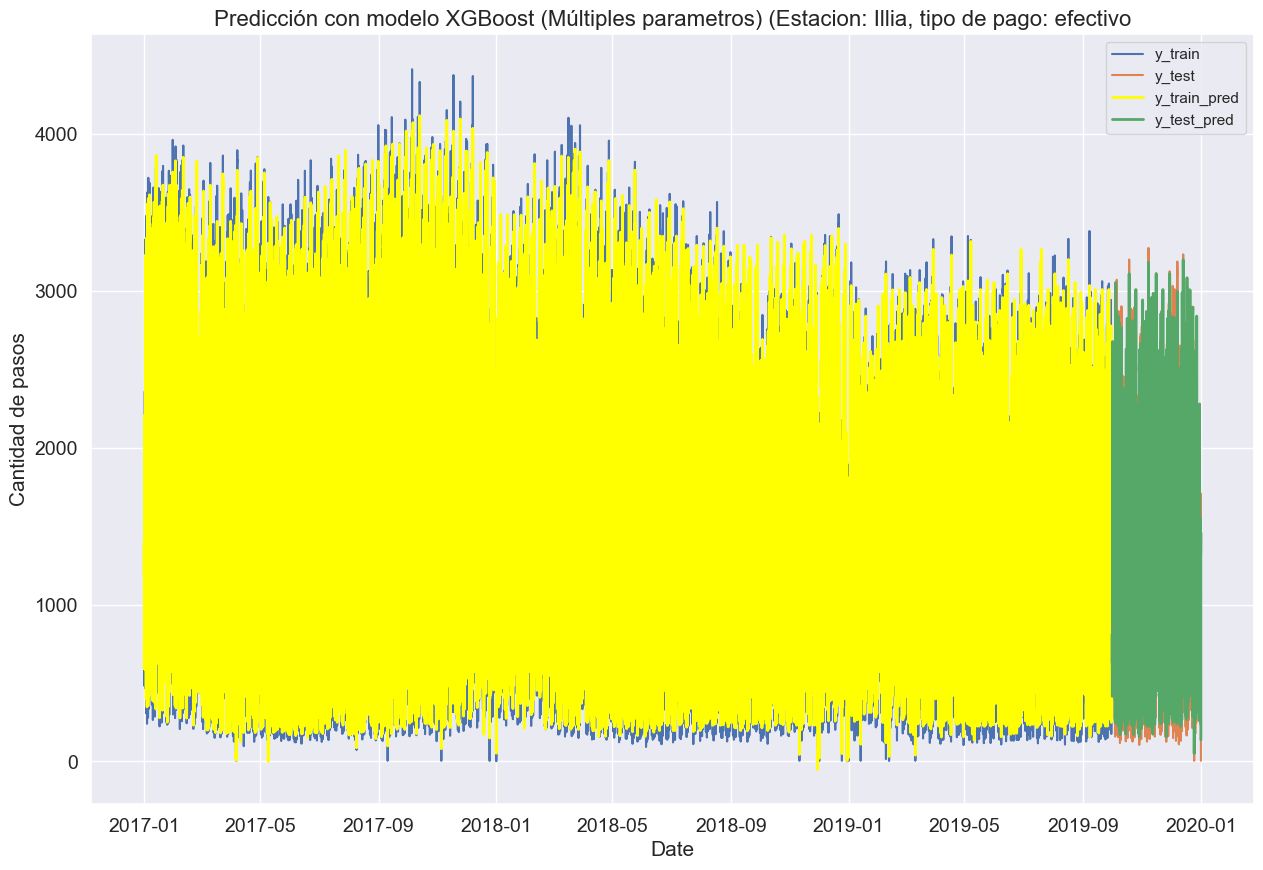

In [190]:
plt.figure(figsize = (15,10))
# Series de datos de la gráfica
plt.plot(train_df.index, train_df.cantidad_pasos, label = 'y_train')
plt.plot(test_df.index, test_df.cantidad_pasos, label = 'y_test')
plt.plot(train_df.index, y_train_pred, label = 'y_train_pred', color='yellow', lw = 2)
plt.plot(test_df.index, y_test_pred, label = 'y_test_pred',  lw = 2)
#Formato de la gráfica
plt.title('Predicción con modelo XGBoost (Múltiples parametros) (Estacion: Illia, tipo de pago: efectivo',fontsize=16)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Cantidad de pasos', fontsize=15)
plt.tick_params(labelsize=14)
plt.legend()

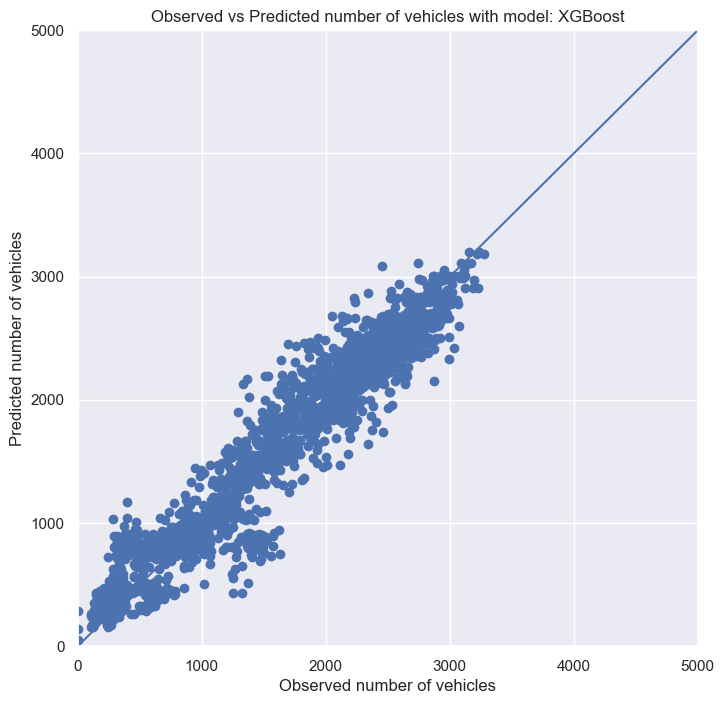

In [191]:
plot_predvstrue_reg(y_test_pred, y_test1, model_name = 'XGBoost')

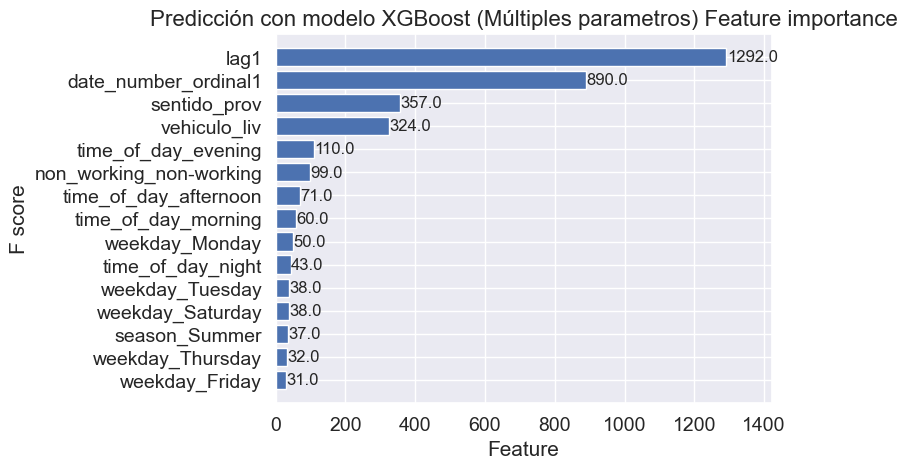

In [192]:
plot_importance(reg, height=0.8,max_num_features=15)
plt.title('Predicción con modelo XGBoost (Múltiples parametros) Feature importance',fontsize=16)
plt.xlabel('Feature', fontsize=15)
plt.ylabel('F score', fontsize=15)
plt.tick_params(labelsize=14)
plt.show()

In [193]:
#In train and test
error3=error_metrics(y_train_pred, y_train, model_name = 'XGBoost', test = False)
error4=error_metrics(y_test_pred, y_test, model_name = 'XGBoost', test = True)
cols=["label","value"]
results3 = pd.DataFrame(list(error3.items()),columns = cols) 
results4=pd.DataFrame(error4.items(),columns=cols)
resultdf=resultdf.merge(results3,how="left",on="label")
resultdf=resultdf.merge(results4,how="left",on="label")
resultdf.columns.values[1] = "linear regression-train"
resultdf.columns.values[2] = "linear regression-test"
resultdf.columns.values[3] = "XGBoost-train"
resultdf.columns.values[4] = "XGBoost-test"
resultdf

label linear regression-train linear regression-test XGBoost-train  \
0       model       linear regression      linear regression       XGBoost   
1  train_test                   train                   test         train   
2        RMSE              324.322668             267.104865    243.509145   
3          R2                0.902616               0.904319      0.945101   
4         MAE              245.126924             205.767745     179.54414   
5        MAPE               65.564289              31.018962     27.275529   

  XGBoost-test  
0      XGBoost  
1         test  
2   233.955051  
3     0.926595  
4   177.221473  
5    25.248674

XGBoost aun sin optimizar hiperparametros mejora cada metrica obteniendo un menor error por unidad de vehiculo predicho, un R2 mas cerca a 1 afirmando una buena prediccion, un menor error y porcentaje respecto al error absoluto medio.

##### Tunning Hyperparameters

In [194]:
xgb_model=xgb.XGBRegressor()

In [195]:
param_rs = {'nthread':[1, 2, 3, 4, 5], 
              'objective':['reg:squarederror'],
              'learning_rate': np.arange(.05, 1, .05),
              'max_depth': np.arange(1,10),
              'min_child_weight': [3, 4, 5, 6, 7, 8],
              'subsample': np.arange(.05, 1, .05),
              'colsample_bytree': np.arange(.05, 1, .05),
              'n_estimators': [200, 300, 400, 500, 600]}
param_rs

{'nthread': [1, 2, 3, 4, 5],
 'objective': ['reg:squarederror'],
 'learning_rate': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
        0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
 'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 'min_child_weight': [3, 4, 5, 6, 7, 8],
 'subsample': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
        0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
 'colsample_bytree': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
        0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
 'n_estimators': [200, 300, 400, 500, 600]}

In [27]:
xgb_rs = RandomizedSearchCV(xgb_model, param_rs,n_iter=50, random_state=0, cv=5,
                            scoring='neg_root_mean_squared_error', verbose=True, n_jobs=-1, refit=True)

In [28]:
xgb_rs.fit(X_train, y_train1,
        eval_set=[(X_train, y_train1), (X_test, y_test1)],
        early_stopping_rounds=50,
        verbose=True)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[0]	validation_0-rmse:1914.47375	validation_1-rmse:1631.94108
[1]	validation_0-rmse:1728.72482	validation_1-rmse:1472.37910
[2]	validation_0-rmse:1561.85592	validation_1-rmse:1327.69820
[3]	validation_0-rmse:1412.22246	validation_1-rmse:1198.91089
[4]	validation_0-rmse:1277.87254	validation_1-rmse:1083.97735
[5]	validation_0-rmse:1156.54373	validation_1-rmse:980.09800
[6]	validation_0-rmse:1048.58219	validation_1-rmse:888.42837
[7]	validation_0-rmse:951.62874	validation_1-rmse:804.68669
[8]	validation_0-rmse:866.09085	validation_1-rmse:733.17490
[9]	validation_0-rmse:789.41753	validation_1-rmse:669.30797
[10]	validation_0-rmse:720.74384	validation_1-rmse:612.12826
[11]	validation_0-rmse:659.67766	validation_1-rmse:559.98948
[12]	validation_0-rmse:605.09983	validation_1-rmse:519.22577
[13]	validation_0-rmse:557.85599	validation_1-rmse:482.47021
[14]	validation_0-rmse:516.03630	validation_1-rmse:448.67401
[15]	validation_0-rms

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
                                        'max_depth

In [29]:
#Guardamos el modelo
filename = path+'/XGBoost_Model.sav'
pickle.dump(xgb_rs, open(filename, 'wb'))

In [196]:
#Cargado del modelo entrenado
filename = path+'/XGBoost_Model.sav'
xgb_rs = pickle.load(open(filename, 'rb'))

In [197]:
xgb_rs.best_score_

-275.12572201638085

In [198]:
xgb_rs.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.9000000000000001, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=-1, grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=5, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=1, nthread=1,
             num_parallel_tree=1, predictor='auto', ...)

In [199]:
list(xgb_rs.cv_results_.keys())

['mean_fit_time',
 'std_fit_time',
 'mean_score_time',
 'std_score_time',
 'param_subsample',
 'param_objective',
 'param_nthread',
 'param_n_estimators',
 'param_min_child_weight',
 'param_max_depth',
 'param_learning_rate',
 'param_colsample_bytree',
 'params',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'mean_test_score',
 'std_test_score',
 'rank_test_score']

In [200]:
best_score = np.argmax(xgb_rs.cv_results_['mean_test_score'])
print('mean_test_f1', xgb_rs.cv_results_['mean_test_score'][best_score])
print('params', xgb_rs.cv_results_['params'][best_score])

mean_test_f1 -275.12572201638085
params {'subsample': 0.25, 'objective': 'reg:squarederror', 'nthread': 1, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.9000000000000001}


In [201]:
y_train_pred1 = xgb_rs.predict(X_train)
y_test_pred1= xgb_rs.predict(X_test)

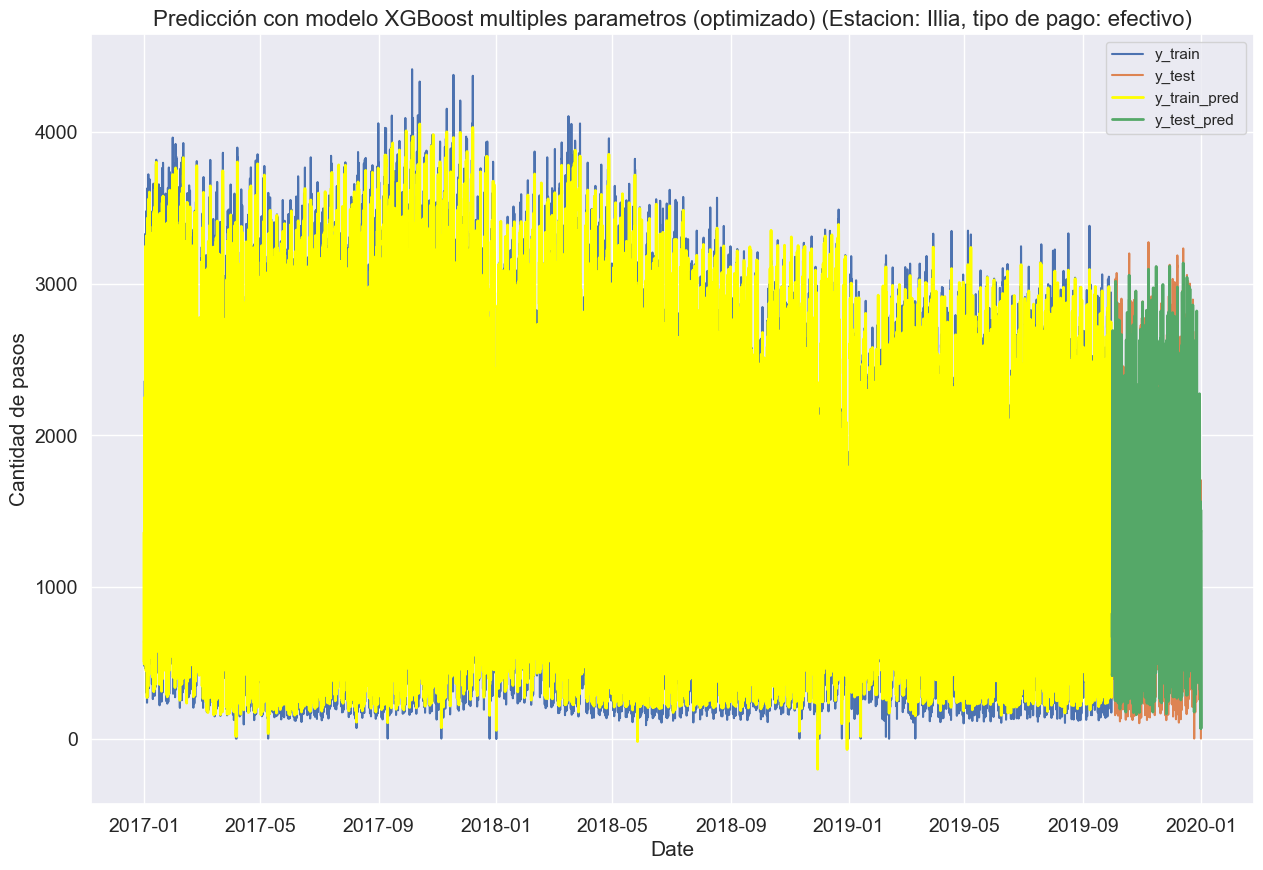

In [202]:
plt.figure(figsize = (15,10))
# Series de datos de la gráfica
plt.plot(train_df.index, train_df.cantidad_pasos, label = 'y_train')
plt.plot(test_df.index, test_df.cantidad_pasos, label = 'y_test')
plt.plot(train_df.index, y_train_pred1, label = 'y_train_pred', color='yellow', lw = 2)
plt.plot(test_df.index, y_test_pred1, label = 'y_test_pred',  lw = 2)
#Formato de la gráfica
plt.title('Predicción con modelo XGBoost multiples parametros (optimizado) (Estacion: Illia, tipo de pago: efectivo)',fontsize=16)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Cantidad de pasos', fontsize=15)
plt.tick_params(labelsize=14)
plt.legend()

In [203]:
#In train and test
error5=error_metrics(y_train_pred1, y_train, model_name = 'XGBoost optimizado', test = False)
error6=error_metrics(y_test_pred1, y_test, model_name = 'XGBoost optimizado', test = True)
cols=["label","value"]
results5 = pd.DataFrame(list(error5.items()),columns = cols) 
results6=pd.DataFrame(error6.items(),columns=cols)
resultdf=resultdf.merge(results5,how="left",on="label")
resultdf=resultdf.merge(results6,how="left",on="label")

In [204]:
resultdf

label linear regression-train linear regression-test XGBoost-train  \
0       model       linear regression      linear regression       XGBoost   
1  train_test                   train                   test         train   
2        RMSE              324.322668             267.104865    243.509145   
3          R2                0.902616               0.904319      0.945101   
4         MAE              245.126924             205.767745     179.54414   
5        MAPE               65.564289              31.018962     27.275529   

  XGBoost-test             value_x             value_y  
0      XGBoost  XGBoost optimizado  XGBoost optimizado  
1         test               train                test  
2   233.955051          256.886213          235.783129  
3     0.926595            0.938903            0.925443  
4   177.221473          188.461098          176.794748  
5    25.248674           37.920115           27.060233

Aun con los hiperparametros optimizados, XGBoost sin optimizacion muestra un mejor desempeño tanto para el train como para el test, con menor variacion en las metricas.

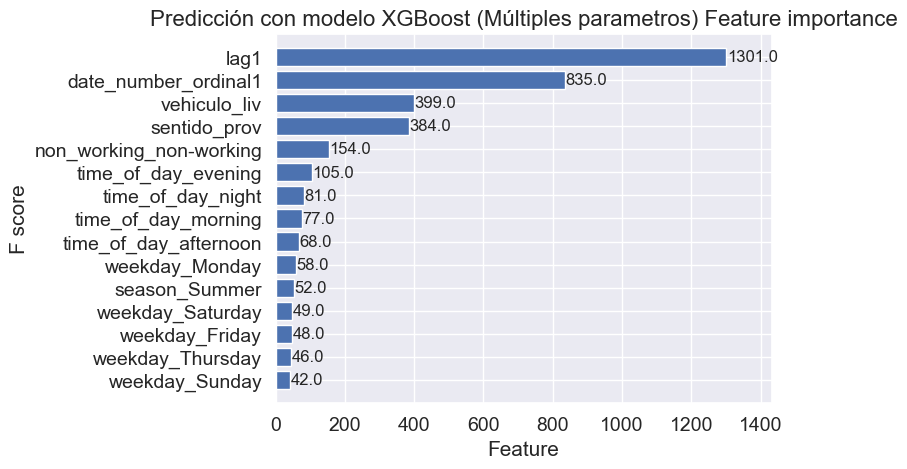

In [205]:
#Informacion que usa el modelo para predecir
plot_importance(xgb_rs.best_estimator_, height=0.8,max_num_features=15)
plt.title('Predicción con modelo XGBoost (Múltiples parametros) Feature importance',fontsize=16)
plt.xlabel('Feature', fontsize=15)
plt.ylabel('F score', fontsize=15)
plt.tick_params(labelsize=14)
plt.show()

Las variables mas importantes son:
- Variable lag1: es la variable que mayor importancia presenta dentro del valor predicho hace referencia al trafico en la hora precedente y si no se consideran eventos puntuales, es de esperarse que tenga una mayor importancia en la predicción del modelo.
- Variable date number ordinal1: Esta variable hace uso de la fecha en el formato numerico, y para considerar la hora se agrego dos digitos al final representando la hora de la observacion esto agrega la idea de cronologia.
- Variable vehiculo_liv: esta variable fue desarrollada de forma que nos diera la relacion entre los vehiculos livianos y el total de vehiculos encontrados, significa entonces que el porcentaje de vehiculos livianos encontrados por observacion influyen o son los mas vistos en el trafico de este peaje.

#### Predicción 2020

Elijo XGBoost sin optimizacion para hacer una prediccion por hora para el primer trimestre del 2020, dado que ya no se dispone de la data real respecto al 2020 se usaran solo datos referidos al tiempo por lo que se reharan los 3 modelos para ver cual es el mejor con estas variables.

In [69]:
dti = pd.date_range("2020-01-01 00:00:00", periods=2184, freq="H")
df_future_dates = pd.DataFrame(dti, columns = ['DateTime'])
df_future_dates

DateTime
0    2020-01-01 00:00:00
1    2020-01-01 01:00:00
2    2020-01-01 02:00:00
3    2020-01-01 03:00:00
4    2020-01-01 04:00:00
...                  ...
2179 2020-03-31 19:00:00
2180 2020-03-31 20:00:00
2181 2020-03-31 21:00:00
2182 2020-03-31 22:00:00
2183 2020-03-31 23:00:00

[2184 rows x 1 columns]

**Creando Features**

In [73]:
def season_calc(month):
    #https://seasonsyear.com/Argentina
    """considering months from December to February are denoted as 'summer' and months from June to February as 'winter'. """
    if month in [9,10,11]:
        return "Spring"
    elif month in [12,1,2]:
        return "Summer"
    elif month in [3,4,5]:
        return "Autumn"
    else:
        return "Winter"
    
def time_of_day(x):
    if x in hour_dict['morning']:
        return 'morning'
    elif x in hour_dict['afternoon']:
        return 'afternoon'
    elif x in hour_dict['evening']:
        return 'evening'
    else:
        return 'night'
    
weekdays = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3: 'Thursday', 4: 'Friday', 5:'Saturday', 6:'Sunday'}

In [157]:
dfr=df_future_dates.copy()
dfr['weekday'] = dfr.DateTime.dt.weekday.map(weekdays)
dfr['season'] = dfr.DateTime.dt.month.apply(season_calc)
#encaso de perder las columnas
dfr['year']=dfr.DateTime.dt.year
dfr['month']=dfr.DateTime.dt.month
dfr['day']=dfr.DateTime.dt.day
dfr['hour']=dfr.DateTime.dt.hour
dfr['Date'] = pd.to_datetime({'year':dfr.year, 'month': dfr.month, 'day': dfr.day})

start=dfr['Date'].min()
end = dfr['Date'].max()

#Feriados en Argentina
holidays_temp=[ (2,14),(3,24),(3,25),(3,27),(4,2),(5,1),(5,25),(6,20),(7,9),(8,17),(9,11),(10,7),(10,10),(10,31),(12,8),(12,11),(12,24),(12,31)]
years=dfr.year.unique()
holidays=[]
for a in holidays_temp:
    for year in years:
        x = datetime.date(year, a[0], a[1])
        if x>start and x<end:
            holidays.append(x)
            
#Adding holidays column to indicate whether a day was a holiday as per the argentinian calendar or not
dfr['holiday'] = dfr['Date'].isin(holidays)
#converting the holiday column to 1 and 0, 1 indicating a holiday and 0 not a holiday; using dictionary and map to achieve this
mapped = {True:1, False:0}
dfr.holiday = dfr.holiday.map(mapped)


#adding in another column which indicates 'non-working' days which include weekends and holidays
dfr['non_working'] = dfr.apply(lambda x: 'non-working' if \
                                         ((x['holiday'] == 1) or (x['weekday'] in ['Saturday', 'Sunday']))
                                         else 'working', axis = 1)

# Dividing the hours into 4 groups-> night, morning, afternoon, evening
hour_dict = {'morning': list(np.arange(7,13)),'afternoon': list(np.arange(13,16)), 'evening': list(np.arange(16,22)),
            'night': [22, 23, 0, 1, 2, 3, 4, 5, 6]}

dfr['time_of_day'] = dfr['hour'].apply(time_of_day)
dfr['date_number_ordinal']=dfload.DateTime.map(datetime.datetime.toordinal)
digits=2
num1 = dfr.date_number_ordinal * (10**digits)
num1 += dfr.hour
dfr['date_number_ordinal1']=num1

# creating categorical columns for linear regression 
cat_cols = ['season', 'weekday','holiday', 'non_working','time_of_day']

for col in cat_cols:
    dfr[col] = dfr[col].astype('category')
    
cols_use = ['cantidad_pasos', 'date_number_ordinal1','Date','DateTime','time_of_day','season', 'non_working','weekday','holiday']
 
def customize_df(df,x):
    df.reset_index(drop=True, inplace=True)
    df = pd.get_dummies(df[cols_use])
    return df

dfr=customize_df(dfr,1)
#dfr=dfr.set_index('DateTime')
dfr.head(5)

cantidad_pasos  date_number_ordinal1       Date            DateTime  \
0             NaN              73633000 2020-01-01 2020-01-01 00:00:00   
1             NaN              73633001 2020-01-01 2020-01-01 01:00:00   
2             NaN              73633002 2020-01-01 2020-01-01 02:00:00   
3             NaN              73633003 2020-01-01 2020-01-01 03:00:00   
4             NaN              73633004 2020-01-01 2020-01-01 04:00:00   

   time_of_day_afternoon  time_of_day_evening  time_of_day_morning  \
0                      0                    0                    0   
1                      0                    0                    0   
2                      0                    0                    0   
3                      0                    0                    0   
4                      0                    0                    0   

   time_of_day_night  season_Autumn  season_Summer  ...  non_working_working  \
0                  1              0              1  ...                    1   
1                  1              0              1  ...                    1   
2                  1              0              1  ...                    1   
3                  1              0              1  ...                    1   
4                  1              0              1  ...                    1   

   weekday_Friday  weekday_Monday  weekday_Saturday  weekday_Sunday  \
0               0               0                 0               0   
1               0               0                 0               0   
2               0               0                 0               0   
3               0               0                 0               0   
4               0               0                 0               0   

   weekday_Thursday  weekday_Tuesday  weekday_Wednesday  holiday_0  holiday_1  
0                 0                0                  1          1          0  
1                 0                0                  1          1          0  
2                 0                0                  1          1          0  
3                 0                0                  1          1          0  
4                 0                0                  1          1          0  

[5 rows x 21 columns]

In [175]:
dfr['cantidad_pasos'] = np.nan
dfr.index = pd.to_datetime(dfr['DateTime'], format='%Y-%m-%d %H:%M:%S')
X_test=dfr.drop(["cantidad_pasos",'Date'], axis = 1)
y_test=dfr.cantidad_pasos.values
y_test1=dfr.cantidad_pasos.values.reshape(-1, 1)

In [176]:
#se limita a las columns que existen para el 2020
train_df2020 = df1_lags.drop(['Date','lag1','sentido_prov','vehiculo_liv','season_Spring','season_Winter'], axis = 1)
X_train2020=train_df2020.drop(["cantidad_pasos"], axis = 1)
y_train2020 = train_df2020.cantidad_pasos.values
y_train2020_1 = train_df2020.cantidad_pasos.values.reshape(-1, 1)

**LinearRegression**

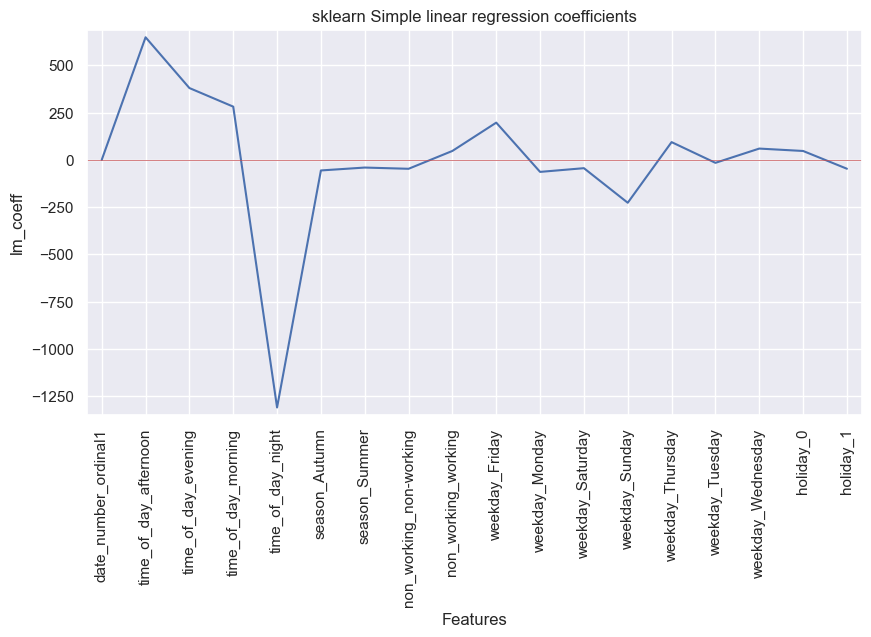

In [177]:
lm = LinearRegression()
lm.fit(X_train2020, y_train2020)
# Ploting the coefficients
_ = plt.figure(figsize = (10, 5))
_ = plt.plot(range(len(X_train2020.columns)), lm.coef_)
_ = plt.xticks(range(len(X_train2020.columns)), X_train2020.columns.values, rotation = 90)
_ = plt.margins(0.02)
_ = plt.axhline(0, linewidth = 0.5, color = 'r')
_ = plt.title('sklearn Simple linear regression coefficients')
_ = plt.ylabel('lm_coeff')
_ = plt.xlabel('Features')

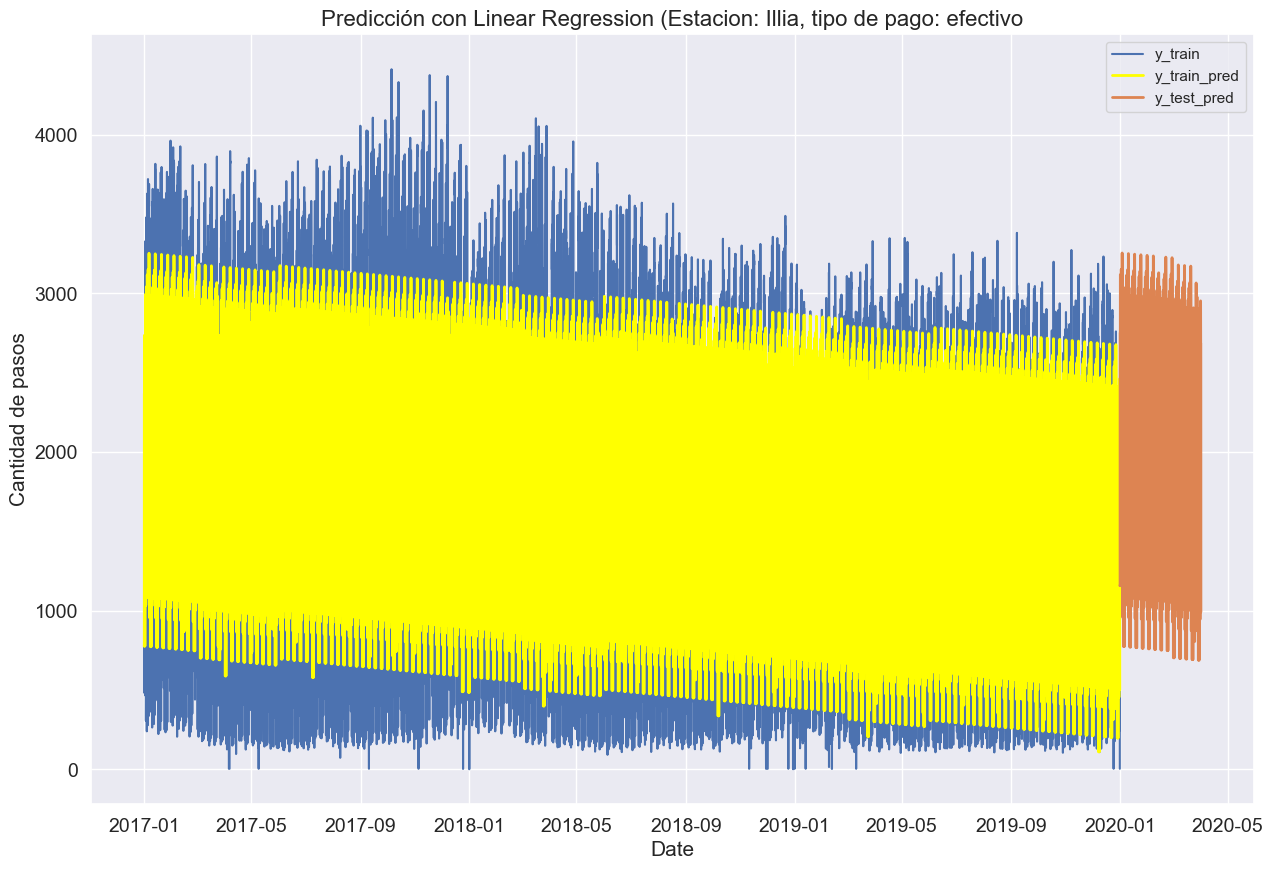

In [178]:
cols=['date_number_ordinal1', 'time_of_day_afternoon', 'time_of_day_evening',
       'time_of_day_morning', 'season_Autumn', 'non_working_working',
       'weekday_Friday', 'weekday_Monday', 'weekday_Saturday',
       'weekday_Sunday', 'weekday_Thursday',
       'weekday_Wednesday', 'holiday_0']
X_train2020_2=X_train2020[cols]
X_test=X_test[cols]

lm.fit(X_train2020_2, y_train2020)

plt.figure(figsize = (15,10))
# Series de datos de la gráfica
plt.plot(train_df2020.index, train_df2020.cantidad_pasos, label = 'y_train')
plt.plot(train_df2020.index, lm.predict(X_train2020_2), label = 'y_train_pred', color='yellow', lw = 2)
plt.plot(dfr.index, lm.predict(X_test), label = 'y_test_pred',  lw = 2)
#Formato de la gráfica
plt.title('Predicción con Linear Regression (Estacion: Illia, tipo de pago: efectivo',fontsize=16)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Cantidad de pasos', fontsize=15)
plt.tick_params(labelsize=14)
plt.legend()

In [179]:
#In train
error1=error_metrics(lm.predict(X_train2020_2), y_train2020, model_name = 'linear regression', test = False)
cols=["label","value"]
results = pd.DataFrame(list(error1.items()),columns = cols) 
results

label              value
0       model  linear regression
1  train_test              train
2        RMSE         557.230868
3          R2           0.706254
4         MAE         447.335783
5        MAPE         200.865787

**XGBoost**

In [181]:
reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
reg.fit(X_train2020_2, y_train2020)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [182]:
y_train_pred1 = reg.predict(X_train2020_2)
y_test_pred1= reg.predict(X_test)

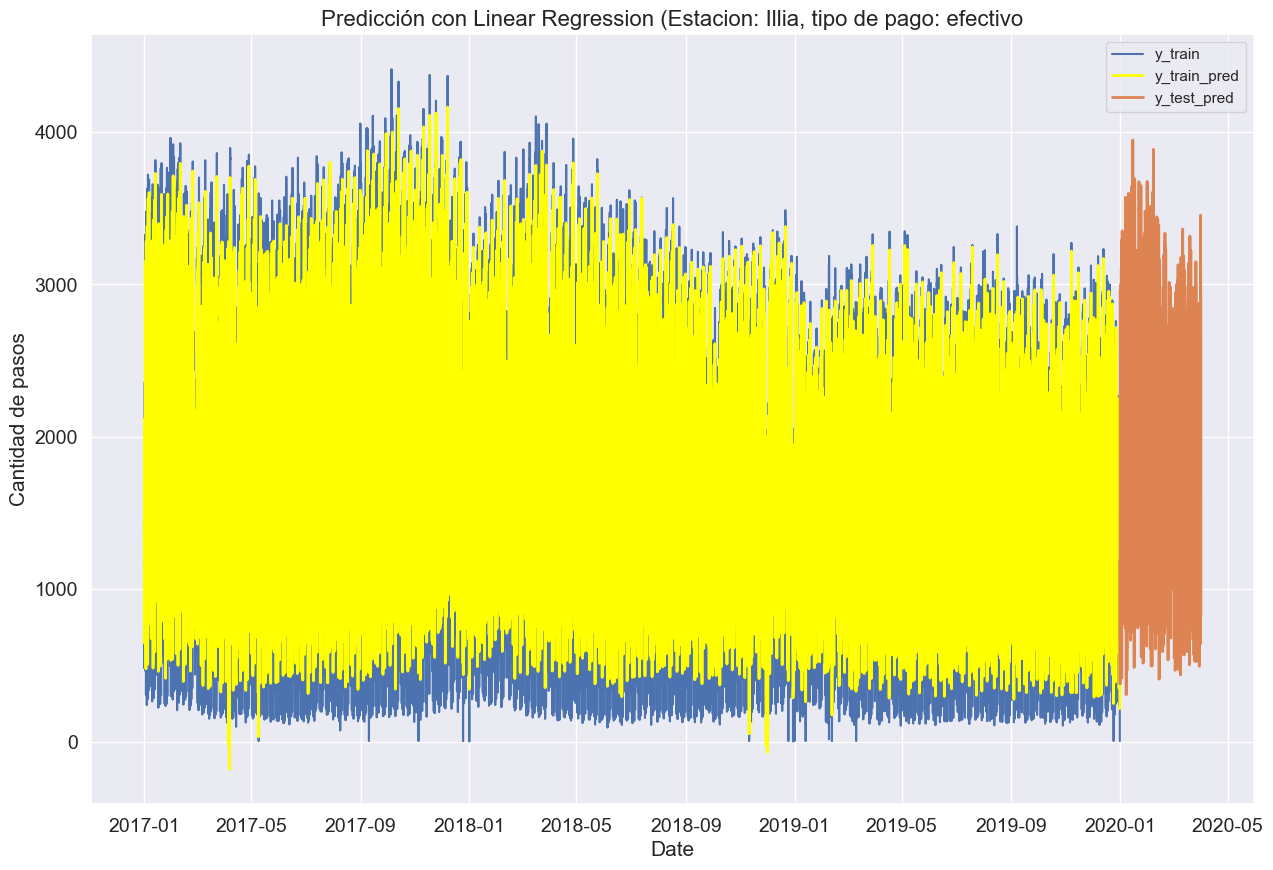

In [184]:
plt.figure(figsize = (15,10))
# Series de datos de la gráfica
plt.plot(train_df2020.index, train_df2020.cantidad_pasos, label = 'y_train')
plt.plot(train_df2020.index, y_train_pred1, label = 'y_train_pred', color='yellow', lw = 2)
plt.plot(dfr.index, y_test_pred1, label = 'y_test_pred',  lw = 2)
#Formato de la gráfica
plt.title('Predicción con Linear Regression (Estacion: Illia, tipo de pago: efectivo',fontsize=16)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Cantidad de pasos', fontsize=15)
plt.tick_params(labelsize=14)
plt.legend()

In [197]:
temp=df1_lags[['Date']].copy()
temp["pred"]=y_train_pred1
temp1=X_test[[]].copy()
temp1["pred"]=y_test_pred1
temp1["Date"]=temp1.index.date
temp2=pd.concat([temp,temp1])
temp2

Date         pred
DateTime                                             
2017-01-01 01:00:00  2017-01-01 00:00:00  1456.157959
2017-01-01 02:00:00  2017-01-01 00:00:00  1456.157959
2017-01-01 03:00:00  2017-01-01 00:00:00  1456.157959
2017-01-01 04:00:00  2017-01-01 00:00:00   647.200989
2017-01-01 05:00:00  2017-01-01 00:00:00   647.200989
...                                  ...          ...
2020-03-31 19:00:00           2020-03-31  2936.104492
2020-03-31 20:00:00           2020-03-31  2936.104492
2020-03-31 21:00:00           2020-03-31  2633.327881
2020-03-31 22:00:00           2020-03-31  1381.464233
2020-03-31 23:00:00           2020-03-31   826.851379

[28367 rows x 2 columns]

Componentes de la Serie

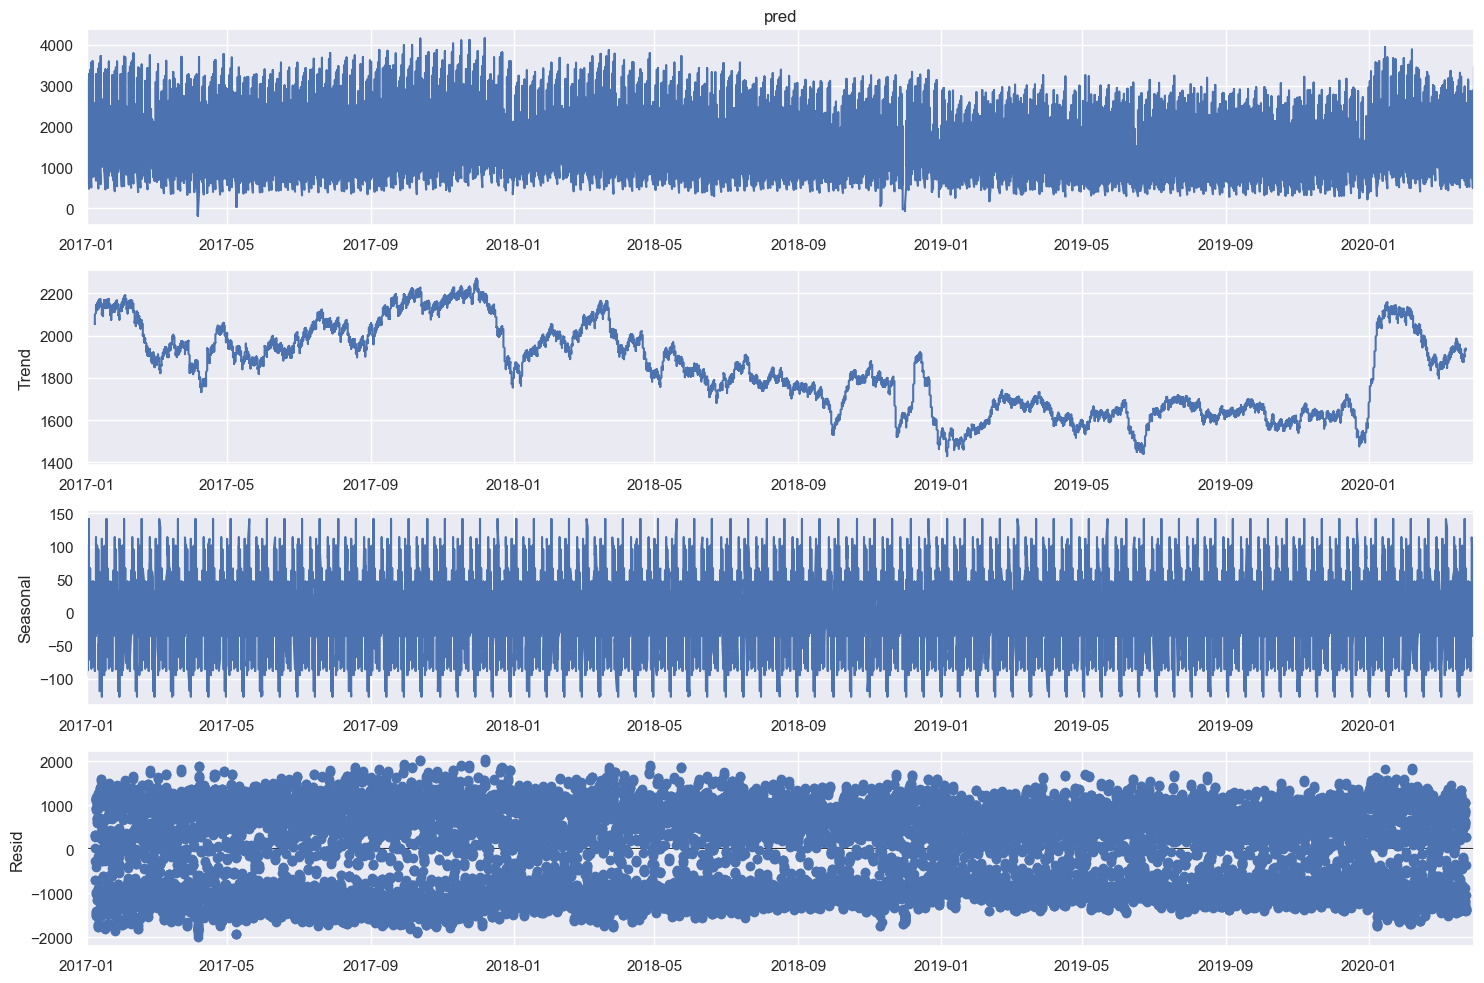

In [199]:
plt.rcParams['figure.figsize'] = [15,10]
result_additive = seasonal_decompose(temp2.set_index('Date').pred, period=365, model='additive')
result_additive.plot()
plt.show()

Dado que no se cuenta con los datos reales se evaluan los componentes, se puede ver que mantiene la tendencia de incrementar en el primer tremestre presente en el 2017 y 2018.

### Investigación

En la prediccion anterior considere usar la informacion sobre el tipo de vehiculo, sentido, dia de la semana, etc, en el caso del Benchmark los coeficientes relacionados a estos parametros producian en el caso del tipo de vehiculo datos muy negativos, en el sentido no influian en la prediccion, y los de dias de la semana si tenian mucho peso.
Podria incluir tambien la variable que cree donde nos daba un score respecto a las otras formas de pago para cada observacion. Decidi aplicar Long Short-Term Memory que es una version avanzada de redes neuronales recurrentes.

#### Flujo de Trabajo
Adicional a los etapas ya presentadas y detalladas a lo largo del proyecto (preparación del dataset de análisis, análisis exploratorio de datos, feature engineering, etc) presentamos algunas en las que deberemos hacer especial énfasis al momento al implementar redes neuronales LSTM:

- Definición de las librerías a emplear: con el fin de optimizar el tiempo de desarrollo es importante evaluar y definir la librería que permita hacer una implementación ágil del modelo elegido. Para el caso de las redes Neuronales LSTM la librería Keras proporciona un método específico para crear capas LSTM, al mismo tiempo que permite definir una arquitectura para para los diferentes parámetros y arquitectura de la red (número de capas, número de nodos en la capa, cuota de dropout, etc.). Fuente a consultar: enlace oficial de Keras en relación con redes LSTM.
- Normalización de los datos: dado que nuestro problema involucra redes neuronales como solución, es fundamental generar una normalización de los datos, pues el resultado o la predicción de este tipo de redes son muy sensibles a las magnitudes de los parámetros de entrada a emplear. Fuente a consultar: Why Data should be Normalized before Training a Neural Network.
- Compilación de los modelos y entrenamiento: La redes neuronales requieren un proceso de compilación en el cual se transforma la secuencia simple de capas en una serie de transformaciones matriciales que deben ser altamente eficientes en un formato destinado a ser ejecutado en la GPU o CPU, dependiendo de la configuración de Keras. Una vez compiladas pasaremos a la etapa de entrenamiento. Fuente a consultar: The 5 Step Life-Cycle for Long Short-Term Memory Models in Keras.
- Revision del sobreajuste del modelo: otra problemática importante a evaluar en el caso de las redes neuronales es el sobreajuste del modelo.

#### Aplicacion

Objetivo: Reducir las métricas RMSE y MAPE

In [13]:
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
import sklearn
import torch

Data

In [10]:
dfload1=pd.read_csv(path+'/DatasetTotalEstaciones.csv',index_col = [0], parse_dates=['Date','DateTime'])
dfload2=pd.read_csv(path+'/timeseries_Illia_fullcolumns.csv',index_col = [0], parse_dates=['Date','DateTime'])
dfload1=dfload1[['DateTime','forma_pago_EFECTIVO', 'otras_forma_pago']][dfload1.estacion=="Illia"]

In [107]:
finaldf=dfload2.merge(dfload1,how="left",on="DateTime")
finaldf.columns

Index(['cantidad_pasos', 'date_number_ordinal1', 'Date', 'DateTime', 'lag1',
       'sentido_prov', 'vehiculo_liv', 'time_of_day_afternoon',
       'time_of_day_evening', 'time_of_day_morning', 'time_of_day_night',
       'season_Autumn', 'season_Spring', 'season_Summer', 'season_Winter',
       'non_working_non-working', 'non_working_working', 'weekday_Friday',
       'weekday_Monday', 'weekday_Saturday', 'weekday_Sunday',
       'weekday_Thursday', 'weekday_Tuesday', 'weekday_Wednesday', 'holiday_0',
       'holiday_1', 'forma_pago_EFECTIVO', 'otras_forma_pago'],
      dtype='object')

In [108]:
finaldf.set_index('DateTime', inplace=True)
finaldf.head()

cantidad_pasos  date_number_ordinal1       Date    lag1  \
DateTime                                                                       
2017-01-01 01:00:00          1374.0              73633001 2017-01-01     1.0   
2017-01-01 02:00:00          1734.0              73633002 2017-01-01  1374.0   
2017-01-01 03:00:00          1247.0              73633003 2017-01-01  1734.0   
2017-01-01 04:00:00           579.0              73633004 2017-01-01  1247.0   
2017-01-01 05:00:00           645.0              73633005 2017-01-01   579.0   

                     sentido_prov  vehiculo_liv  time_of_day_afternoon  \
DateTime                                                                 
2017-01-01 01:00:00      0.500000      0.666667                      0   
2017-01-01 02:00:00      0.500000      0.666667                      0   
2017-01-01 03:00:00      0.428571      0.571429                      0   
2017-01-01 04:00:00      0.400000      0.800000                      0   
2017-01-01 05:00:00      0.571429      0.571429                      0   

                     time_of_day_evening  time_of_day_morning  \
DateTime                                                        
2017-01-01 01:00:00                    0                    0   
2017-01-01 02:00:00                    0                    0   
2017-01-01 03:00:00                    0                    0   
2017-01-01 04:00:00                    0                    0   
2017-01-01 05:00:00                    0                    0   

                     time_of_day_night  ...  weekday_Monday  weekday_Saturday  \
DateTime                                ...                                     
2017-01-01 01:00:00                  1  ...               0                 0   
2017-01-01 02:00:00                  1  ...               0                 0   
2017-01-01 03:00:00                  1  ...               0                 0   
2017-01-01 04:00:00                  1  ...               0                 0   
2017-01-01 05:00:00                  1  ...               0                 0   

                     weekday_Sunday  weekday_Thursday  weekday_Tuesday  \
DateTime                                                                 
2017-01-01 01:00:00               1                 0                0   
2017-01-01 02:00:00               1                 0                0   
2017-01-01 03:00:00               1                 0                0   
2017-01-01 04:00:00               1                 0                0   
2017-01-01 05:00:00               1                 0                0   

                     weekday_Wednesday  holiday_0  holiday_1  \
DateTime                                                       
2017-01-01 01:00:00                  0          1          0   
2017-01-01 02:00:00                  0          1          0   
2017-01-01 03:00:00                  0          1          0   
2017-01-01 04:00:00                  0          1          0   
2017-01-01 05:00:00                  0          1          0   

                     forma_pago_EFECTIVO  otras_forma_pago  
DateTime                                                    
2017-01-01 01:00:00                  6.0          0.333333  
2017-01-01 02:00:00                  6.0          0.350000  
2017-01-01 03:00:00                  7.0          0.300000  
2017-01-01 04:00:00                  5.0          0.315789  
2017-01-01 05:00:00                  7.0          0.300000  

[5 rows x 27 columns]

In [132]:
#Ultimo trimestre 2019 oct,nov,dic
finaldf=finaldf[['cantidad_pasos', 'Date']]
df_test = finaldf[(finaldf.Date<="2019-12-31")&(finaldf.Date>="2019-10-01")].drop(["Date"],axis=1)
df_val = finaldf[(finaldf.Date<"2019-10-01")&(finaldf.Date>="2019-07-01")].drop(["Date"],axis=1)
df_train = finaldf[(finaldf.Date<"2019-07-01")].drop(["Date"],axis=1)

X_test=df_test.drop(["cantidad_pasos"], axis = 1)
X_train=df_train.drop(["cantidad_pasos"], axis = 1)
X_val=df_val.drop(["cantidad_pasos"], axis = 1)

y_test = df_test.cantidad_pasos
y_train = df_train.cantidad_pasos
y_val = df_val.cantidad_pasos

In [133]:
#Scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_arr = scaler.fit_transform(df_train)
val_arr = scaler.transform(df_val)
test_arr = scaler.transform(df_test)

**Data Transformation**
Se transforma una larga secuencia de data en otras aun mas cortas. Considerare una secuencia de 100 time bars(horas) con variacion de hora en hora.

In [134]:
def transform_data(arr, seq_len):
    x, y = [], []
    for i in range(len(arr) - seq_len):
        x_i = arr[i : i + seq_len]
        y_i = arr[i + 1 : i + seq_len + 1]
        x.append(x_i)
        y.append(y_i)
    x_arr = np.array(x).reshape(-1, seq_len)
    y_arr = np.array(y).reshape(-1, seq_len)
    x_var = Variable(torch.from_numpy(x_arr).float())
    y_var = Variable(torch.from_numpy(y_arr).float())
    return x_var, y_var

from torch.autograd import Variable
seq_len = 100

x_train, y_train = transform_data(train_arr, seq_len)
x_val, y_val = transform_data(val_arr, seq_len)
x_test, y_test = transform_data(test_arr, seq_len)

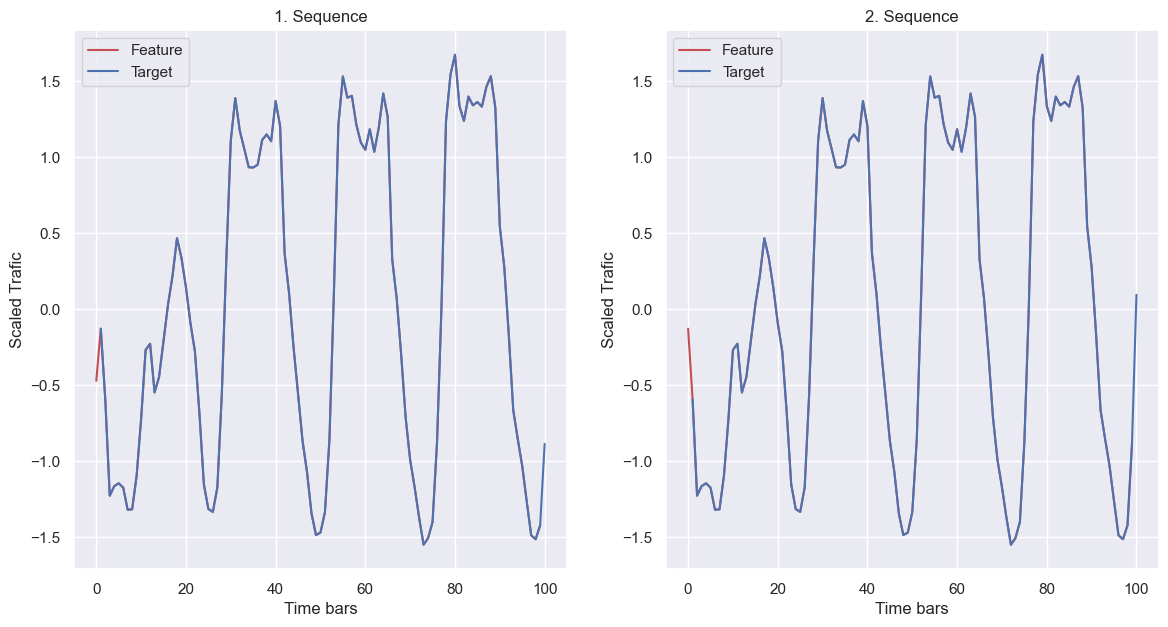

In [135]:
def plot_sequence(axes, i, x_train, y_train):
    axes[i].set_title("%d. Sequence" % (i + 1))
    axes[i].set_xlabel("Time bars")
    axes[i].set_ylabel("Scaled Trafic")
    axes[i].plot(range(seq_len), x_train[i].cpu().numpy(), color="r", label="Feature")
    axes[i].plot(range(1, seq_len + 1), y_train[i].cpu().numpy(), color="b", label="Target")
    axes[i].legend()
    
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
plot_sequence(axes, 0, x_train, y_train)
plot_sequence(axes, 1, x_train, y_train)

Los plots muestran la 1ra y 2da secuencia, ambas de longitud de 100 horas, se puede observar que Feature y Target son similes, LSTM, en cada secuencia para predecir el target en una hora, toma el feature de la hora precedente y asi sucesivamente.
Cuando varia de secuencia hace un shift de 1hr de la feature de la secuencia precedente, con este procedimiento se puede obtener muchas secuencias con un shift de solo 1hr.

#### Long Short Term Memory Neural Network

In [142]:
import torch.nn as nn
import torch.optim as optim


class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm = nn.LSTMCell(self.input_size, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, input, future=0, y=None):
        outputs = []

        # reset the state of LSTM
        # the state is kept till the end of the sequence
        h_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)
        c_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm(input_t, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]

        for i in range(future):
            if y is not None and random.random() > 0.5:
                output = y[:, [i]]  # teacher forcing
            h_t, c_t = self.lstm(output, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [137]:
import time
import random


class Optimization:
    """ A helper class to train, test and diagnose the LSTM"""

    def __init__(self, model, loss_fn, optimizer, scheduler):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_losses = []
        self.val_losses = []
        self.futures = []

    @staticmethod
    def generate_batch_data(x, y, batch_size):
        for batch, i in enumerate(range(0, len(x) - batch_size, batch_size)):
            x_batch = x[i : i + batch_size]
            y_batch = y[i : i + batch_size]
            yield x_batch, y_batch, batch

    def train(
        self,
        x_train,
        y_train,
        x_val=None,
        y_val=None,
        batch_size=100,
        n_epochs=15,
        do_teacher_forcing=None,
    ):
        seq_len = x_train.shape[1]
        for epoch in range(n_epochs):
            start_time = time.time()
            self.futures = []

            train_loss = 0
            for x_batch, y_batch, batch in self.generate_batch_data(x_train, y_train, batch_size):
                y_pred = self._predict(x_batch, y_batch, seq_len, do_teacher_forcing)
                self.optimizer.zero_grad()
                loss = self.loss_fn(y_pred, y_batch)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
            self.scheduler.step()
            train_loss /= batch
            self.train_losses.append(train_loss)

            self._validation(x_val, y_val, batch_size)

            elapsed = time.time() - start_time
            print(
                "Epoch %d Train loss: %.2f. Validation loss: %.2f. Avg future: %.2f. Elapsed time: %.2fs."
                % (epoch + 1, train_loss, self.val_losses[-1], np.average(self.futures), elapsed)
            )

    def _predict(self, x_batch, y_batch, seq_len, do_teacher_forcing):
        if do_teacher_forcing:
            future = random.randint(1, int(seq_len) / 2)
            limit = x_batch.size(1) - future
            y_pred = self.model(x_batch[:, :limit], future=future, y=y_batch[:, limit:])
        else:
            future = 0
            y_pred = self.model(x_batch)
        self.futures.append(future)
        return y_pred

    def _validation(self, x_val, y_val, batch_size):
        if x_val is None or y_val is None:
            return
        with torch.no_grad():
            val_loss = 0
            batch = 1
            for x_batch, y_batch, batch in self.generate_batch_data(x_val, y_val, batch_size):
                y_pred = self.model(x_batch)
                loss = self.loss_fn(y_pred, y_batch)
                val_loss += loss.item()
            val_loss /= batch
            self.val_losses.append(val_loss)

    def evaluate(self, x_test, y_test, batch_size, future=1):
        with torch.no_grad():
            test_loss = 0
            actual, predicted = [], []
            for x_batch, y_batch, batch in self.generate_batch_data(x_test, y_test, batch_size):
                y_pred = self.model(x_batch, future=future)
                y_pred = (
                    y_pred[:, -len(y_batch) :] if y_pred.shape[1] > y_batch.shape[1] else y_pred
                )
                loss = self.loss_fn(y_pred, y_batch)
                test_loss += loss.item()
                actual += torch.squeeze(y_batch[:, -1]).data.cpu().numpy().tolist()
                predicted += torch.squeeze(y_pred[:, -1]).data.cpu().numpy().tolist()
            test_loss /= batch
            return actual, predicted, test_loss

    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")

In [151]:
def generate_sequence(scaler, model, x_sample, future=1000):
    """ Generate future values for x_sample with the model """
    y_pred_tensor = model(x_sample, future=future)
    y_pred = y_pred_tensor.cpu().tolist()
    y_pred = scaler.inverse_transform(y_pred)
    return y_pred

def to_dataframe(actual, predicted):
    return pd.DataFrame({"actual": actual, "predicted": predicted})

def inverse_transform(scalar, df, columns):
    for col in columns:
        temp=df[col].values.reshape(-1, 1)
        df[col] = scaler.inverse_transform(temp)
    return df

**Training**

Se usa una cantidad baja de hidden units, para  evitar que LSTM memorice a la perfeccion la secuencia, tambien MSE Loss function y Adam optimizer. Learning rate se inicializa como 0.001 y decrece cada 5 epochs. Se entrena con 100 secuencias por cada batch de 15 epochs.

In [143]:
model_1 = Model(input_size=1, hidden_size=21, output_size=1)
loss_fn_1 = nn.MSELoss()
optimizer_1 = optim.Adam(model_1.parameters(), lr=1e-3)
scheduler_1 = optim.lr_scheduler.StepLR(optimizer_1, step_size=5, gamma=0.1)
optimization_1 = Optimization(model_1, loss_fn_1, optimizer_1, scheduler_1)

In [144]:
optimization_1.train(x_train, y_train, x_val, y_val, do_teacher_forcing=False)

Epoch 1 Train loss: 0.48. Validation loss: 0.09. Avg future: 0.00. Elapsed time: 14.34s.
Epoch 2 Train loss: 0.12. Validation loss: 0.06. Avg future: 0.00. Elapsed time: 19.02s.
Epoch 3 Train loss: 0.09. Validation loss: 0.05. Avg future: 0.00. Elapsed time: 19.02s.
Epoch 4 Train loss: 0.07. Validation loss: 0.04. Avg future: 0.00. Elapsed time: 16.98s.
Epoch 5 Train loss: 0.06. Validation loss: 0.03. Avg future: 0.00. Elapsed time: 17.04s.
Epoch 6 Train loss: 0.06. Validation loss: 0.03. Avg future: 0.00. Elapsed time: 17.47s.
Epoch 7 Train loss: 0.05. Validation loss: 0.03. Avg future: 0.00. Elapsed time: 17.75s.
Epoch 8 Train loss: 0.05. Validation loss: 0.03. Avg future: 0.00. Elapsed time: 20.92s.
Epoch 9 Train loss: 0.05. Validation loss: 0.03. Avg future: 0.00. Elapsed time: 22.37s.
Epoch 10 Train loss: 0.05. Validation loss: 0.03. Avg future: 0.00. Elapsed time: 28.26s.
Epoch 11 Train loss: 0.05. Validation loss: 0.03. Avg future: 0.00. Elapsed time: 22.43s.
Epoch 12 Train loss

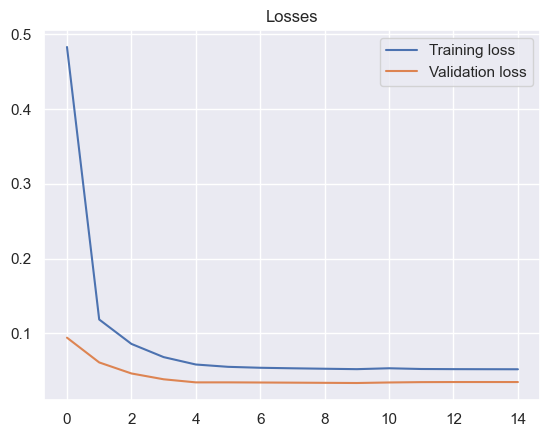

In [145]:
optimization_1.plot_losses()

Training y validation loss llegan a converger pero permanecen constantes con una minima diferencia desde el epoch 7

Evaluando en el test set con el parametro future igual a 5, por ende el modelo predice el trafico donde cree que corresponda en las 5 horas siguientes.

Test loss 1.1128


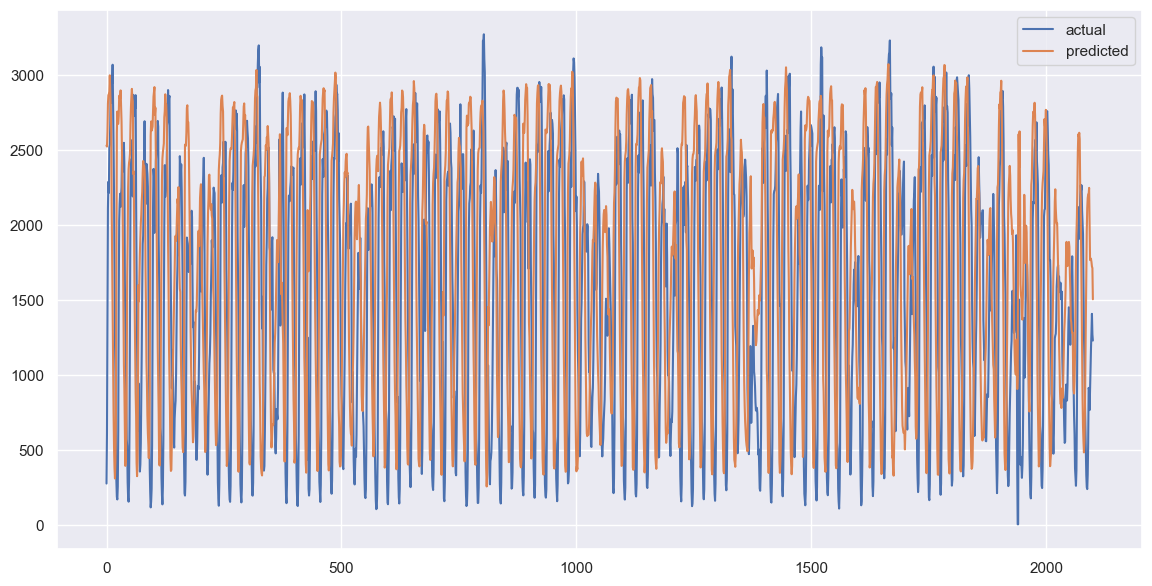

In [154]:
actual_1, predicted_1, test_loss_1 = optimization_1.evaluate(x_test, y_test, future=5, batch_size=100)
df_result_1 = to_dataframe(actual_1, predicted_1) 
df_result_1 = inverse_transform(scaler, df_result_1, ['actual', 'predicted'])
df_result_1.plot(figsize=(14, 7))
print("Test loss %.4f" % test_loss_1)

Se aprecia que la prediccion se acerca al valor real del trafico, la onda deberia presentar las curvas antes, por lo que se hace un zoom.

<AxesSubplot:>

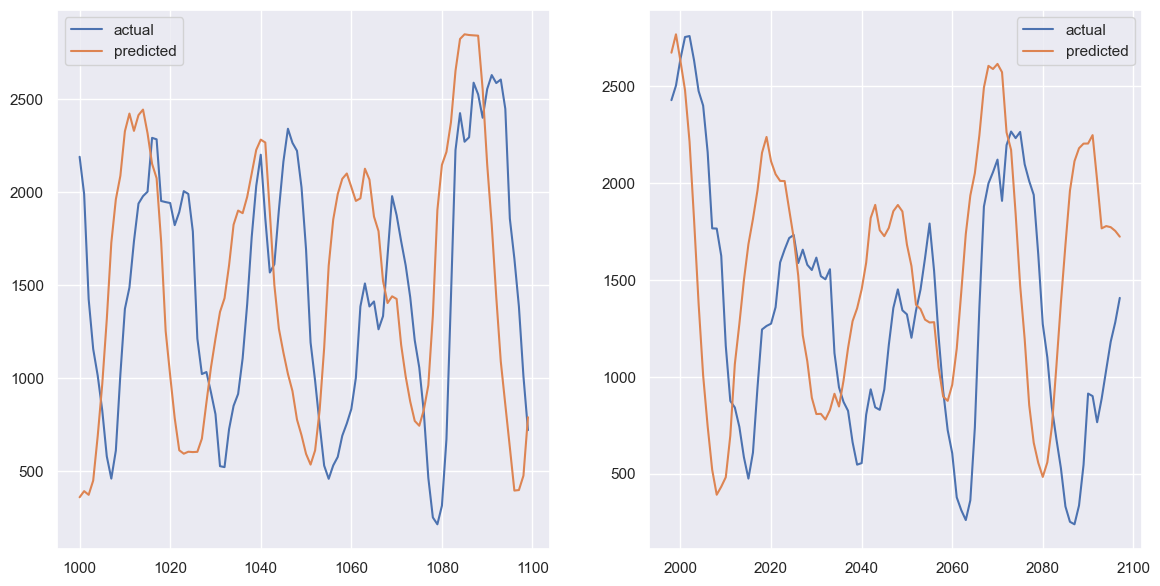

In [162]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
df_result_1.iloc[1000:1100].plot(ax=axes[0], figsize=(14, 7))
df_result_1.iloc[1998:2098].plot(ax=axes[1], figsize=(14, 7))

Es bastante acertado, no detecta las curvas exactas pero si llega a producir una curva similar un tanto mas generica.

**Comentarios/Conclusion**

Las predicciones representan el valor actual del trafico, llega a detectar los cambios antes de que suceda. y eso considerando que solo se uso como variable al trafico, usando el trafico en las horas precedentes. Llega a explicar los picos en time series de manera mucho mas acertada que el Benchmark elegido o XGBoost.